# Main

In [1]:
# import libraries
import pandas as pd
import os.path as osp
import math
import random
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
from skmisc.loess import loess
from matplotlib.ticker import FuncFormatter
import copy


def myround(n, i=0):
    return int(n * 10**i + 0.5) / 10**i


def tick_formatter_func(x, pos):
    if x.is_integer():
        return f"{int(round(x))}"
    else:
        return f"{round(x, 3)}"


tick_formatter = FuncFormatter(tick_formatter_func)

data_path = "../results/formated_data"
figure_path = "../figure"


sns.set(font_scale=0.9)
sns.set(style="ticks")

In [2]:
methods = ["IID", "COV", "ADV", "OOD"]
methodse = ["IID", "COV", "ADV", "OOD", "IID_FIX", "ADV_FIX", "OOD_FIX"]
level_names = {1: "Baseline", 2: "30%", 4: "15%", 8: "7.5%", 16: "3.75%"}
exps = ["Ratio", "Height"]
var = {"Ratio": "Ratio", "Height": "H"}

In [3]:
color_deep4 = ["#dd8452", "#55a868", "#4c72b0", "#a17bc6"]
color_deep4_code = {
    "IID": "#dd8452",
    "COV": "#55a868",
    "ADV": "#4c72b0",
    "OOD": "#a17bc6",
}
color_deep4 = sns.color_palette(color_deep4)
grey6 = sns.color_palette("Greys", 6)  # inferno_r OrRd
grey6r = sns.color_palette("Greys_r", 6)  # inferno_r OrRd

color_deep4

[(0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.6313725490196078, 0.4823529411764706, 0.7764705882352941)]

In [4]:
cnn_H = pd.read_feather(f"{data_path}/cnn_height.feather")
# combined = pd.concat([cnn] + humans, axis=0).reset_index(drop=True)
cnn_H["RawRatio"] = cnn_H.h / cnn_H.H
cnn_H["absError"] = np.abs(cnn_H.RawRatio - cnn_H.Pred)
cnn_H["Error"] = -(cnn_H.RawRatio - cnn_H.Pred)
cnn_H_agg = (
    cnn_H.groupby(["Model", "Run", "Type", "Method", "Level", "h", "H"])[
        ["Pred", "RawRatio", "absError", "Error", "TrainCover"]
    ]
    .mean()
    .dropna()
    .reset_index()
    .groupby(["Model", "Run", "Type", "Method", "Level", "H"])[
        ["Pred", "RawRatio", "absError", "Error", "TrainCover"]
    ]
    .mean()
    .dropna()
    .reset_index()
)
cnn_H_agg["SmallHeight"] = np.where(cnn_H_agg.H < 20, "short", "tall")
cnn_H_cat = cnn_H_agg


cnn_R = pd.read_feather(f"{data_path}/cnn_ratio.feather")
cnn_R["RawRatio"] = cnn_R.h / cnn_R.H
cnn_R["absError"] = np.abs(cnn_R.RawRatio - cnn_R.Pred)
cnn_R["Error"] = -(cnn_R.RawRatio - cnn_R.Pred)
cnn_R["Ratio"] = cnn_R.RawRatio.apply(lambda x: round(x, 2))
cnn_R["SmallHeight"] = np.where(cnn_R.H < 20, "short", "tall")
cnn_R_agg = (
    cnn_R.groupby(["Model", "Run", "Type", "Method", "Level", "h", "H"])[
        ["Pred", "RawRatio", "Ratio", "absError", "Error", "TrainCover"]
    ]
    .mean()
    .dropna()
    .reset_index()
)
cnn_R_agg["Ratio"] = round(cnn_R_agg.RawRatio, 2)
cnn_R_agg = (
    cnn_R_agg.groupby(["Model", "Run", "Type", "Method", "Level", "Ratio"])[
        ["Pred", "RawRatio", "absError", "Error", "TrainCover"]
    ]
    .mean()
    .dropna()
    .reset_index()
)
cnn_R_cat = (
    cnn_R.groupby(["Model", "Run", "Type", "Method", "Level", "h", "H", "SmallHeight"])[
        ["Pred", "RawRatio", "Ratio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
    .groupby(["Model", "Run", "Type", "Method", "Level", "Ratio", "SmallHeight"])[
        ["Pred", "RawRatio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
)


cnn_H_agg["Exp"] = "Height"
cnn_R_agg["Exp"] = "Ratio"
cnn_H_cat["Exp"] = "Height"
cnn_R_cat["Exp"] = "Ratio"
cnn = pd.concat([cnn_H_agg, cnn_R_agg], axis=0).reset_index(drop=True)
# cnn.loc[cnn.H < 20, "SmallHeight"] = "short"
# cnn.loc[cnn.H >= 20, "SmallHeight"] = "tall"
cnn_cat = pd.concat([cnn_H_cat, cnn_R_cat], axis=0).reset_index(drop=True)
cnn_feature = cnn.copy()
cnn_feature = cnn_feature[cnn_feature.Method != "COV"].reset_index(drop=True)
cnn_feature["Feature"] = cnn_feature.Method.apply(
    lambda x: "with" if "_FIX" in x else "without"
)
cnn_feature["Method"] = cnn_feature.Method.apply(lambda x: x.split("_")[0])

cnn_cover = (
    cnn.groupby(["Exp", "Model", "Type", "Method", "Level", "Run"])[
        ["absError", "TrainCover"]
    ]
    .mean()
    .reset_index()
    .dropna()
)

In [5]:
cnn_Hm = pd.read_feather(f"{data_path}/cnn_height_more.feather")
# combined = pd.concat([cnn] + humans, axis=0).reset_index(drop=True)
cnn_Hm["RawRatio"] = cnn_Hm.h / cnn_Hm.H
cnn_Hm["absError"] = np.abs(cnn_Hm.RawRatio - cnn_Hm.Pred)
cnn_Hm["Error"] = -(cnn_Hm.RawRatio - cnn_Hm.Pred)
cnn_Hm_agg = (
    cnn_Hm.groupby(["Model", "Run", "Type", "Method", "Level", "h", "H"])[
        ["Pred", "RawRatio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
    .groupby(["Model", "Run", "Type", "Method", "Level", "H"])[
        ["Pred", "RawRatio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
)

cnn_Rm = pd.read_feather(f"{data_path}/cnn_ratio_more.feather")
cnn_Rm["RawRatio"] = cnn_Rm.h / cnn_Rm.H
cnn_Rm["absError"] = np.abs(cnn_Rm.RawRatio - cnn_Rm.Pred)
cnn_Rm["Error"] = -(cnn_Rm.RawRatio - cnn_Rm.Pred)
cnn_Rm["Ratio"] = cnn_Rm.RawRatio.apply(lambda x: round(x, 2))
cnn_Rm["SmallHeight"] = np.where(cnn_Rm.H < 20, "short", "tall")
cnn_Rm_agg = (
    cnn_Rm.groupby(["Model", "Run", "Type", "Method", "Level", "h", "H"])[
        ["Pred", "RawRatio", "Ratio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
)
cnn_Rm_agg["Ratio"] = round(cnn_Rm_agg.RawRatio, 2)
cnn_Rm_agg = (
    cnn_Rm_agg.groupby(["Model", "Run", "Type", "Method", "Level", "Ratio"])[
        ["Pred", "RawRatio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
)


cnn_Hm_agg["Exp"] = "Height"
cnn_Rm_agg["Exp"] = "Ratio"
cnnm = pd.concat([cnn_Hm_agg, cnn_Rm_agg], axis=0).reset_index(drop=True)
# cnn.loc[cnn.H < 20, "SmallHeight"] = "short"
# cnn.loc[cnn.H >= 20, "SmallHeight"] = "tall"

In [6]:
cnn["Test"] = "Normal"
cnnm["Test"] = "More"
cnn_more = pd.concat([cnn, cnnm], axis=0).reset_index(drop=True)
cnn_more = cnn_more[(cnn_more.Method.isin(methods)) & (cnn_more.Level > 1)]

## Sampling

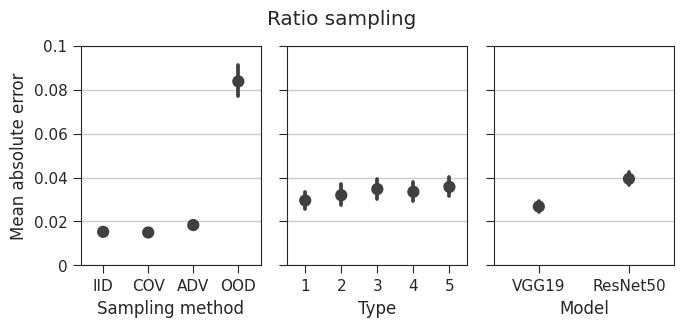

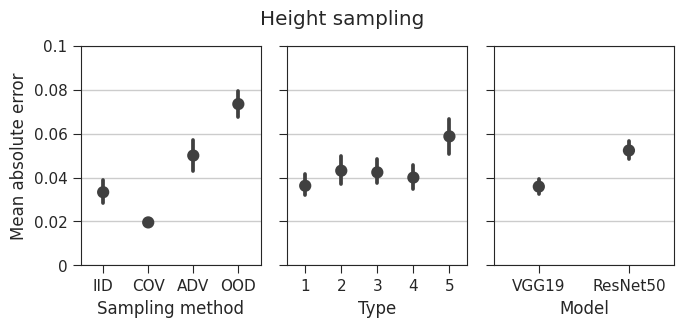

In [17]:
for exp in exps:
    data = cnn[(cnn.Method.isin(methods)) & (cnn.Level == 2) & (cnn.Exp == exp)]
    fig, axes = plt.subplots(1, 3, figsize=(7, 3.5), sharey=True)
    sns.pointplot(
        data=data,
        x="Method",
        y="absError",
        ax=axes[0],
        color="#404040",
        join=False,
        order=methods,
    )
    axes[0].set_xlabel("Sampling method")

    sns.pointplot(
        data=data, x="Type", y="absError", ax=axes[1], color="#404040", join=False
    )

    sns.pointplot(
        data=data,
        x="Model",
        y="absError",
        ax=axes[2],
        color="#404040",
        join=False,
        order=["VGG", "ResNet"],
    )
    axes[2].set_xticklabels(["VGG19", "ResNet50"])
    for i, ax in enumerate(axes):
        ax.grid(True, axis="y")
        ax.set_ylim(0, 0.1)
        if i == 0:
            ax.set_ylabel("Mean absolute error")
            ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1])
            ax.set_yticklabels(["0", "0.02", "0.04", "0.06", "0.08", "0.1"])
        else:
            ax.set_ylabel("")

        for f in ax.spines.values():
            f.set_linewidth(0.8)
        ax.tick_params(width=0.8)

        # if i == 1:
        #     ax.set_xticklabels([f"Type {t}" for t in range(1, 6)])

    plt.suptitle(f"{exp} sampling", y=0.93)
    plt.tight_layout()
    plt.savefig(f"{figure_path}/StudyI{exp}Summary.pdf")
    plt.show()

/users/PAS1575/jiang2126/anaconda3/envs/CP/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_29420/3856350037.py:73: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


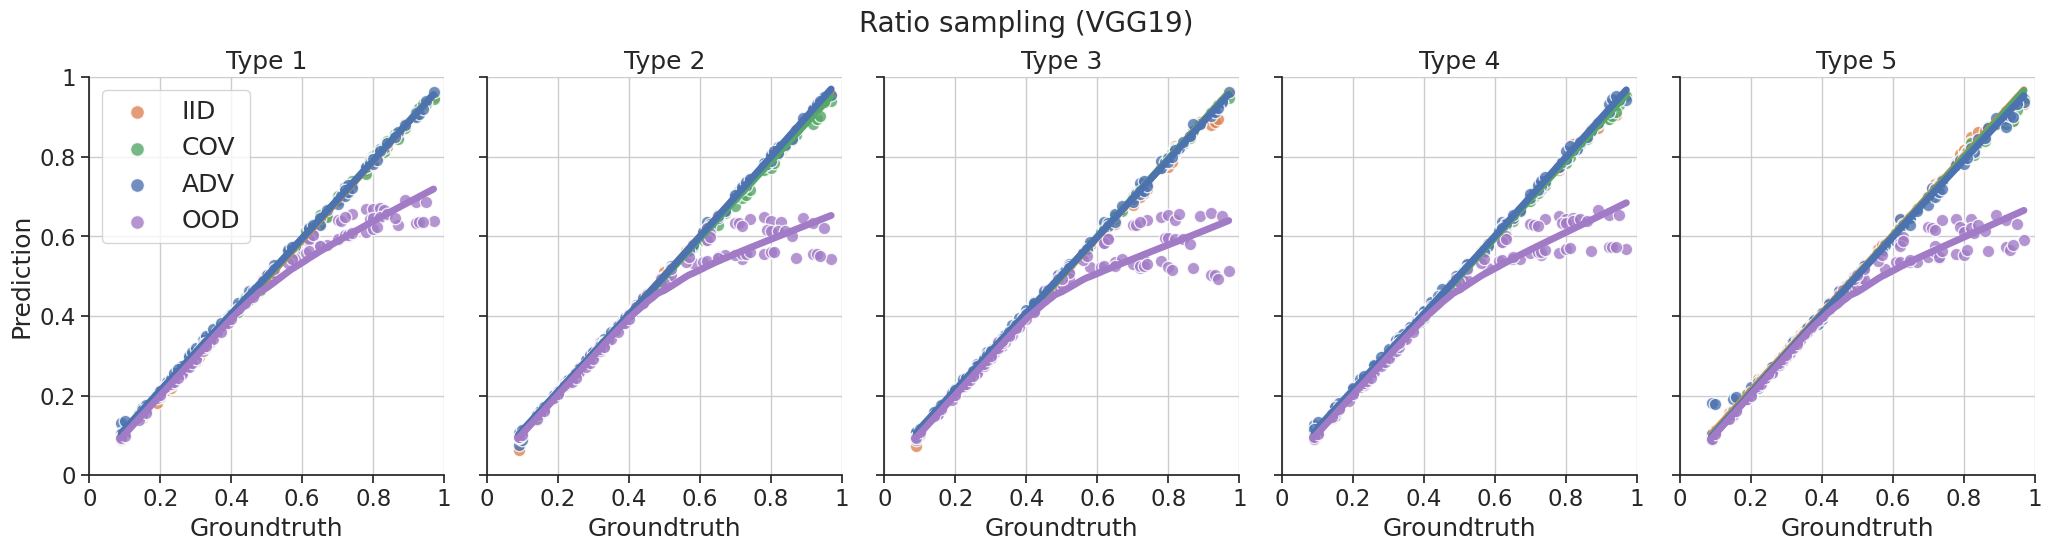

/users/PAS1575/jiang2126/anaconda3/envs/CP/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_29420/3856350037.py:73: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


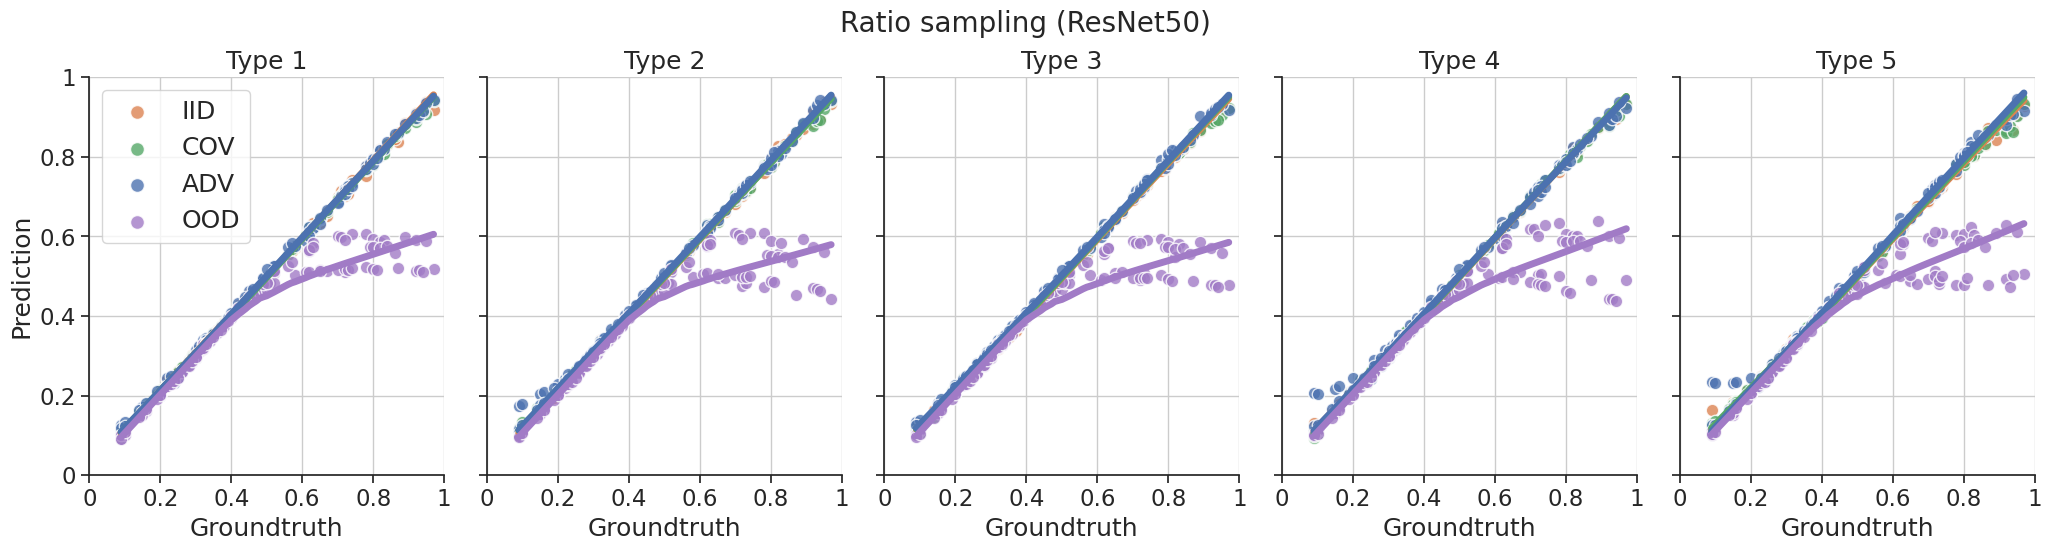

In [53]:
for model in ["VGG", "ResNet"]:
    data = cnn[
        (cnn.Method.isin(methods))
        & (cnn.Level == 2)
        & (cnn.Exp == "Ratio")
        & (cnn.Model == model)
    ]
    # sns.set(style="ticks")
    sns.set(style="ticks", font_scale=1.5)
    # g = sns.relplot(
    #     data=data,
    #     x="Ratio",
    #     y="Pred",
    #     hue="Method",
    #     hue_order=methods,
    #     palette=color_deep4,
    #     col="Type",
    #     # row="Model",
    #     row_order=["VGG", "ResNet"],
    #     kind="scatter",
    #     # linewidth=3,
    #     # scale=1.5,
    #     # legend_out=False,
    #     # legend=False,
    #     aspect=0.65,
    #     height=6
    #     # margin_titles=True,
    # )
    g = sns.lmplot(
        data=data,
        x="Ratio",
        y="Pred",
        hue="Method",
        hue_order=methods,
        palette=color_deep4,
        col="Type",
        # row="Model",
        # row_order=["VGG", "ResNet"],
        lowess=True,
        # linewidth=3,
        # scale=1.5,
        # legend_out=False,
        # legend=False,
        aspect=0.65,
        height=6,
        # margin_titles=True,
        scatter_kws=dict(edgecolors="white", s=80),
        line_kws=dict(lw=5),
    )
    # plt.grid()
    g.set(
        ylim=(0, 1),
        yticks=[0, 0.2, 0.4, 0.6, 0.8, 1],
        yticklabels=["0", 0.2, 0.4, 0.6, 0.8, "1"],
        xlim=(0, 1),
        xticks=[0, 0.2, 0.4, 0.6, 0.8, 1],
        xticklabels=["0", 0.2, 0.4, 0.6, 0.8, "1"],
    )
    g.legend.remove()
    ax = g.axes.flat[0]
    lgnd = ax.legend(fontsize=18)
    for handle in lgnd.legend_handles:
        handle.set_sizes([100])
    for ax in g.axes.flat:
        ax.grid(True, axis="both")
    g.set_axis_labels("Groundtruth", "Prediction")
    g.set_titles(col_template="Type {col_name}")
    plt.suptitle(
        f"Ratio sampling ({'VGG19' if 'VGG' in model else 'ResNet50'})",
        fontsize=20,
        y=0.93,
    )
    plt.tight_layout()
    plt.savefig(f"{figure_path}/StudyIRatio{model}.pdf", bbox_inches="tight")
    plt.show()
    sns.set(style="ticks", font_scale=0.9)

/users/PAS1575/jiang2126/anaconda3/envs/CP/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


/tmp/ipykernel_29420/995724963.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


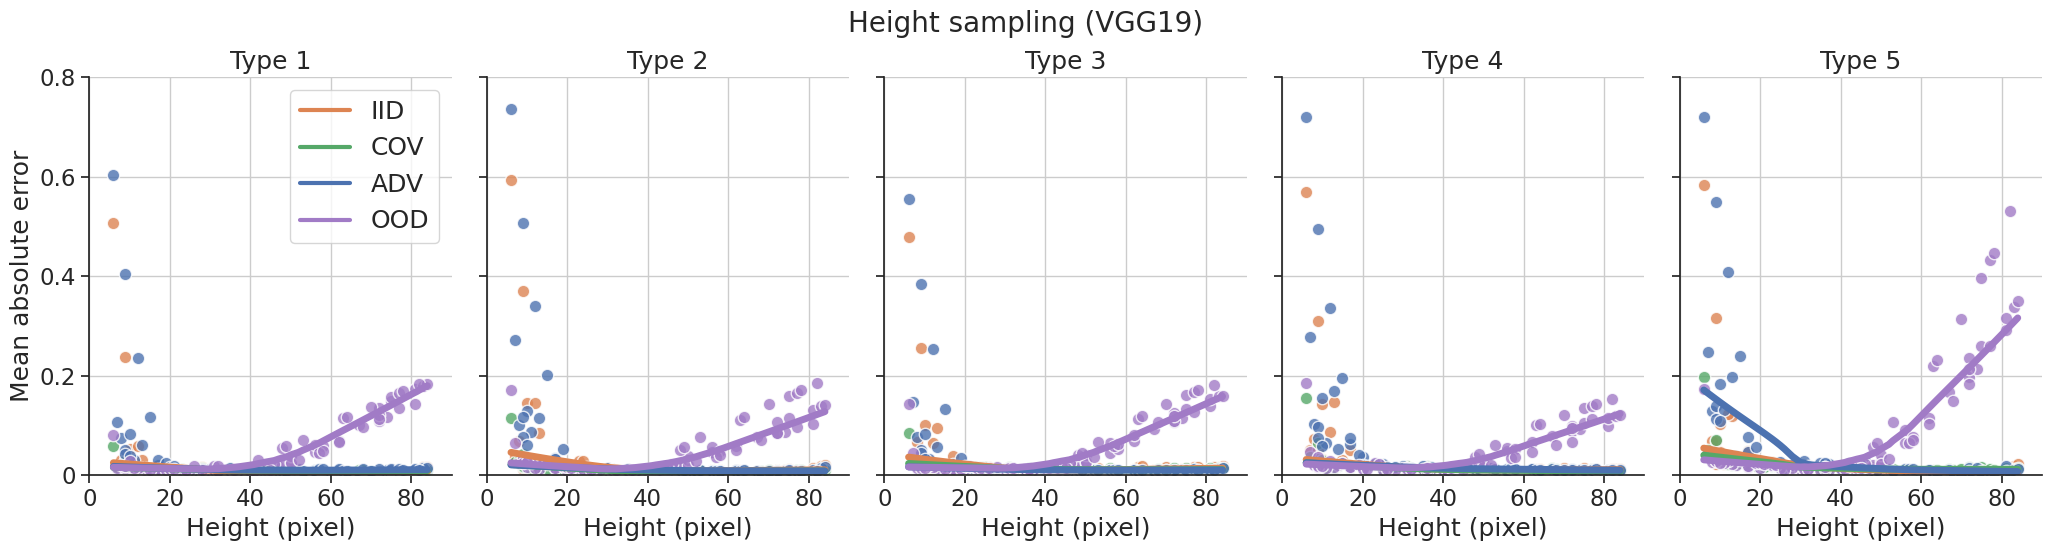

/users/PAS1575/jiang2126/anaconda3/envs/CP/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_29420/995724963.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


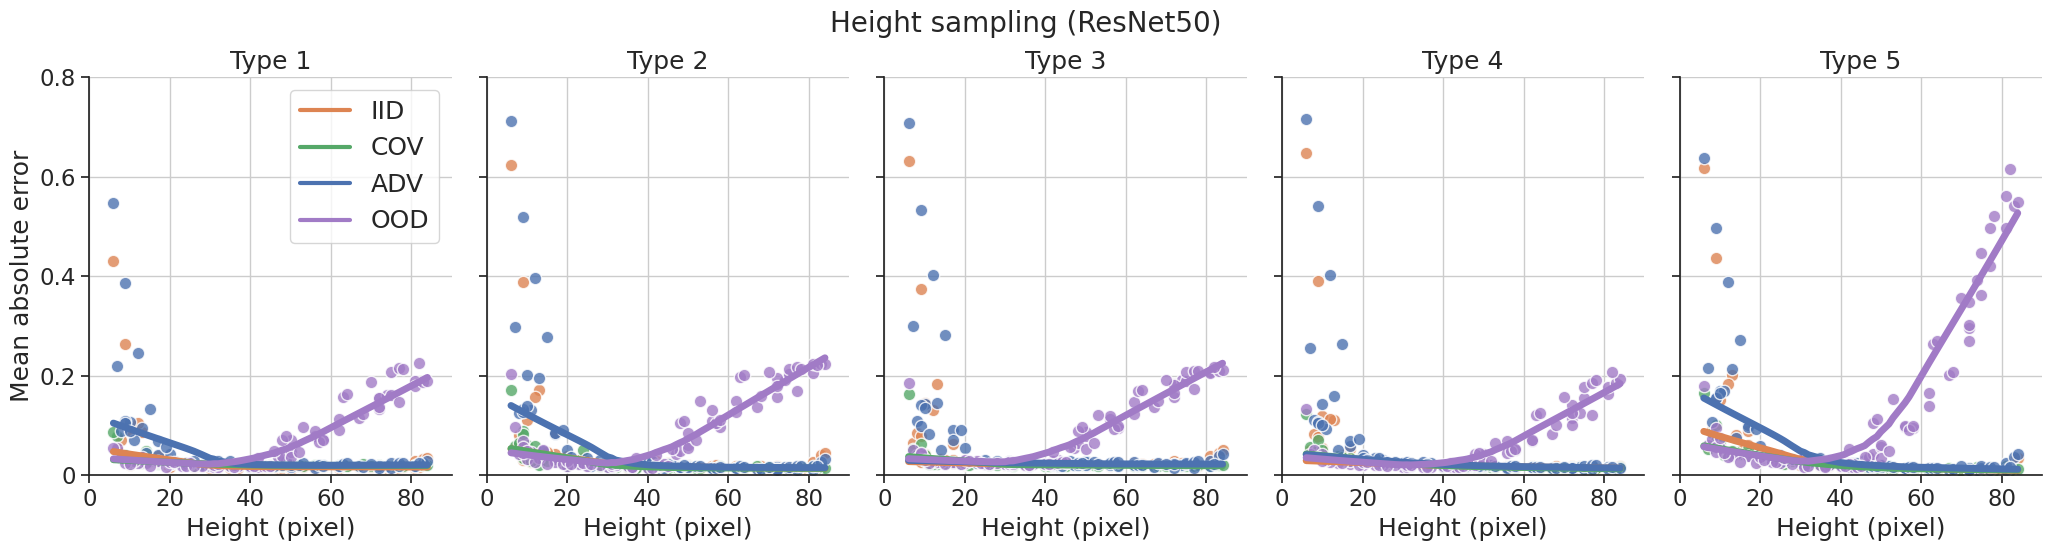

In [56]:
for model in ["VGG", "ResNet"]:
    data = cnn[
        (cnn.Method.isin(methods))
        & (cnn.Level == 2)
        & (cnn.Exp == "Height")
        & (cnn.Model == model)
    ]
    # sns.set(style="ticks")
    sns.set(style="ticks", font_scale=1.5)
    g = sns.lmplot(
        data=data,
        x="H",
        y="absError",
        hue="Method",
        hue_order=methods,
        palette=color_deep4,
        col="Type",
        # row="Model",
        row_order=["VGG", "ResNet"],
        lowess=True,
        # linewidth=3,
        # scale=1.5,
        # legend_out=False,
        # legend=False,
        aspect=0.65,
        height=6,
        scatter_kws=dict(edgecolors="white", s=80),
        line_kws=dict(lw=5),
        # margin_titles=True,
    )
    # plt.grid()
    g.set(
        ylim=(0, 0.8),
        yticks=[0, 0.2, 0.4, 0.6, 0.8],
        yticklabels=["0", 0.2, 0.4, 0.6, 0.8],
        xlim=(0, 90),
        xticks=[0, 20, 40, 60, 80],
        # xticklabels=["0", 0.2, 0.4, 0.6, 0.8, "1"],
    )
    g.legend.remove()
    ax = g.axes.flat[0]
    lgnd = ax.legend(fontsize=18)
    for handle in lgnd.legend_handles:
        handle.set_sizes([100])
    for ax in g.axes.flat:
        ax.grid(True, axis="both")
        # ax.yaxis.set_visible(False)
    g.axes.flat[0].legend(handles=handles, labels=labels, fontsize=18)
    g.set_axis_labels("Height (pixel)", "Mean absolute error")
    g.set_titles(col_template="Type {col_name}")
    plt.suptitle(
        f"Height sampling ({'VGG19' if 'VGG' in model else 'ResNet50'})",
        fontsize=20,
        y=0.93,
    )
    plt.tight_layout()
    plt.savefig(f"{figure_path}/StudyIHeight{model}.pdf", bbox_inches="tight")
    plt.show()
    sns.set(style="ticks", font_scale=0.9)

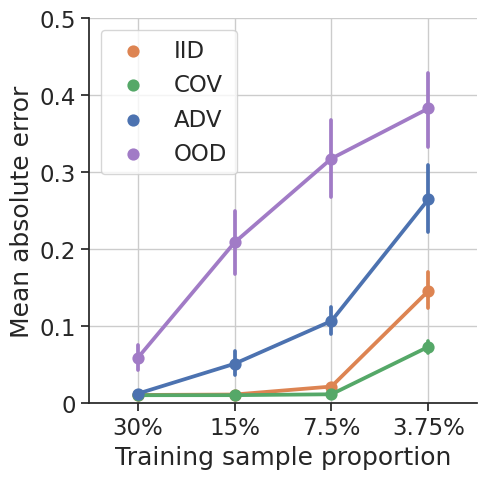

In [12]:
plt.figure(figsize=(5, 5))
sns.set(style="ticks", font_scale=1.5)
data = cnn[
    (cnn.Method.isin(methods))
    & (cnn.Model == "VGG")
    & (cnn.Test == "Normal")
    & (cnn.Exp == "Ratio")
    & (cnn.Type == 1)
]
g = sns.pointplot(
    data=data,
    x="Level",
    order=[2, 4, 8, 16],
    y="absError",
    hue="Method",
    hue_order=methods,
    palette=color_deep4,
)
plt.ylim(0, 0.5)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], ["0", 0.1, 0.2, 0.3, 0.4, 0.5])
plt.gca().set_xticklabels(["30%", "15%", "7.5%", "3.75%"])
plt.ylabel("Mean absolute error")
plt.xlabel("Training sample proportion")
g.legend_.set_title(None)
plt.gca().spines[["right", "top"]].set_visible(False)
plt.grid()
plt.savefig("teaser_resultb.svg", bbox_inches="tight")

/tmp/ipykernel_6024/3667268516.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unc_H_H['byHeight'] = 'Others'
/tmp/ipykernel_6024/3667268516.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unc_H_H['Order'] = 0
/users/PAS1575/chen8028/anaconda3/envs/CP/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.5098039215686274, 0.5098039215686274, 0.5098039215686274)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor o

HeightMAEbyH20.pdf


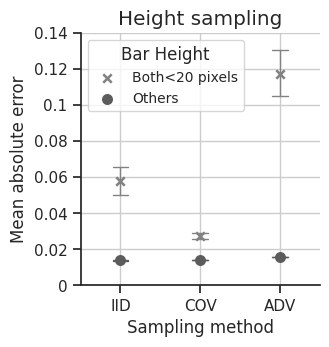

In [61]:
#################### Study I insert figure by H20 category ####################

### add a new column to identify data by H and h
df_unc_H = df_S1height
df_unc_H_H = df_unc_H[df_unc_H['Method']!='OOD']

# num of bar height < 20: 0, 1, 2
df_unc_H_H['byHeight'] = 'Others'
df_unc_H_H.loc[df_unc_H_H[(df_unc_H_H['H']<20) & (df_unc_H_H['h']<20)].index,  'byHeight'] = 'Both<20 pixels'

method_order = {'IID':0,'COV':1,'ADV':2}
df_unc_H_H['Order'] = 0
df_unc_H_H.loc[df_unc_H_H["Method"] == 'COV', "Order"] = 1
df_unc_H_H.loc[df_unc_H_H["Method"] == 'ADV', "Order"] = 2

df_unc_H_H = df_unc_H_H.sort_values(['Order','byHeight'])

# plot
sns.set(font_scale=0.9)
sns.set(style='ticks')  ## use lineplot to add empty markers ###

g = sns.catplot(data=df_unc_H_H, x='Method', y='absError', hue='byHeight', kind='point', height=3.4, aspect=1.1,
                 capsize=0.2, scale=0.9, errwidth=1,  palette=grey_3cols,
                markers=['x', 'o'], linestyles=['',''])
g.set_xlabels('Sampling method', fontsize='medium')
g.set_ylabels('Mean absolute error', fontsize='medium')
plt.ylim(0.0,0.14)
g.set_yticklabels(['0','0.02','0.04','0.06','0.08','0.1','0.12','0.14'])
plt.title('Height sampling', fontsize='large')
g._legend.remove()
plt.legend(loc='upper left', title='Bar Height', fontsize='small')
plt.grid()

fname = 'HeightMAEbyH20.pdf'
print(fname)
plt.savefig(osp.join(figure_path, fname), format='pdf', bbox_inches = 'tight')

## Downsampling

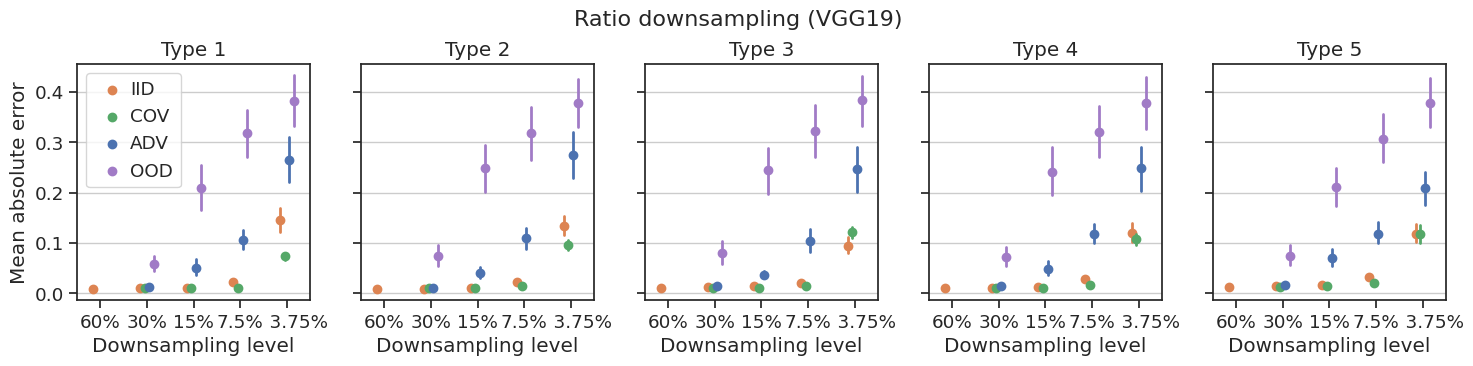

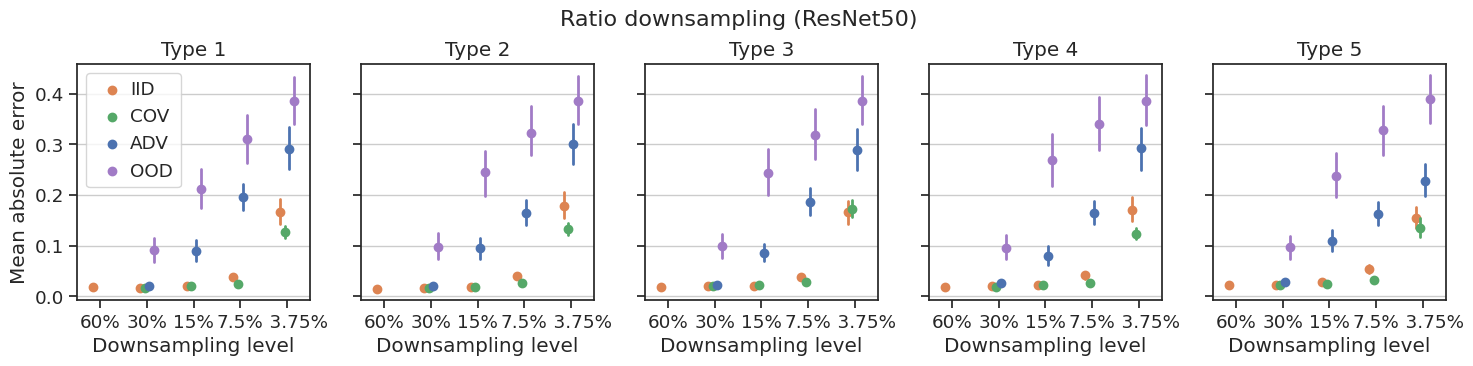

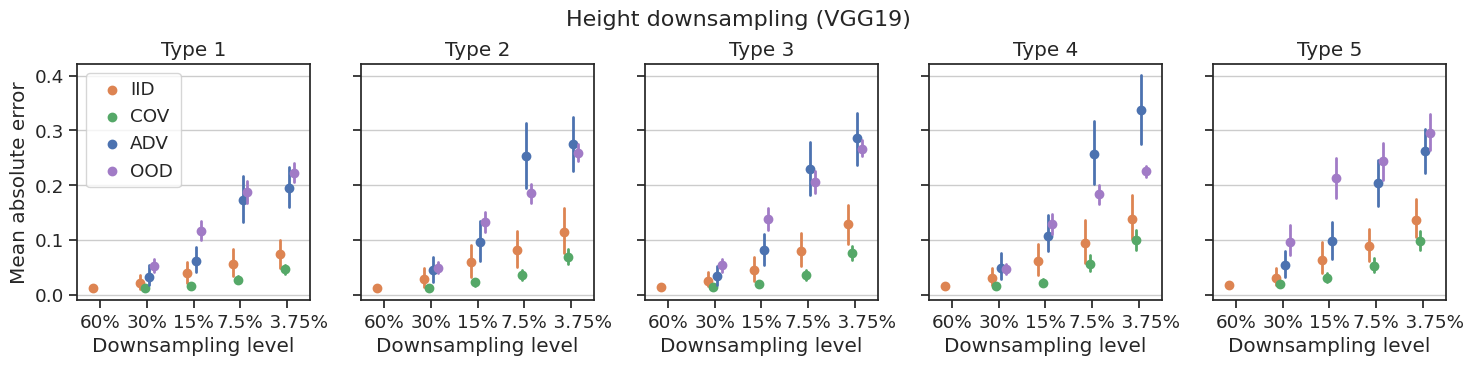

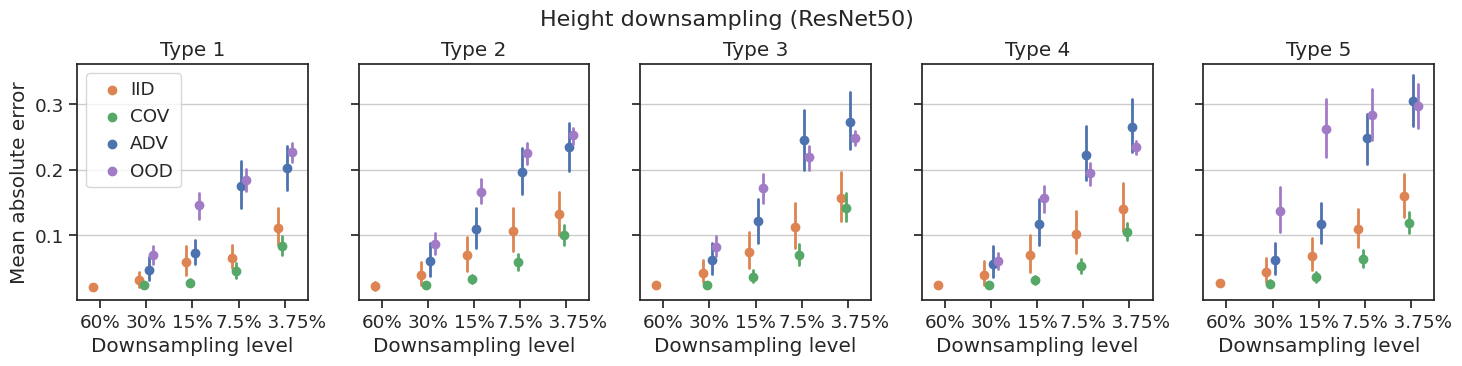

In [30]:
sns.set(font_scale=1.2)
sns.set_style("ticks", rc={"lines.linewidth": 0.1})


for exp in exps:
    for model in ["VGG", "ResNet"]:
        fig, axes = plt.subplots(1, 5, figsize=(15, 4.0), sharey=True)
        # df_load = (
        #     cnn_feature[
        #         (cnn_feature.Exp == exp)
        #         & (cnn_feature.Level.isin([2, 4, 8]))
        #         & (cnn_feature.Model == model)
        #     ]
        #     .groupby(
        #         [
        #             "Model",
        #             "Run",
        #             "Type",
        #             "Method",
        #             "Level",
        #             "Ratio" if exp == "Ratio" else "H",
        #             "Feature",
        #         ]
        #     )[["absError"]]
        #     .mean()
        #     .reset_index()
        #     .pivot(
        #         index=[
        #             "Model",
        #             "Run",
        #             "Type",
        #             "Method",
        #             "Level",
        #             "Ratio" if exp == "Ratio" else "H",
        #         ],
        #         columns="Feature",
        #         values="absError",
        #     )
        #     .reset_index()
        #     .dropna()
        # )
        # df_load["diff"] = df_load["with"] - df_load["without"]
        for bartype in range(1, 6):
            data = cnn[
                (cnn.Method.isin(methods))
                & (cnn.Exp == exp)
                & (cnn.Model == model)
                & (cnn.Type == bartype)
                & (cnn.Level.isin([1, 2, 4, 8, 16]))
            ]
            # fig = plt.figure(figsize=(3.5, 3.75))
            ax = axes[bartype - 1]
            ax.grid(True, axis="y")
            sns.pointplot(
                data=data,
                x="Level",
                y="absError",
                hue="Method",
                hue_order=methods,
                palette=color_deep4,
                join=False,
                dodge=0.3,
                scale=0.8,
                ax=ax,
                # legend=False,
            )
            ax.legend().remove()
            ax.set_ylabel("")
            if bartype == 1:
                ax.legend(handletextpad=0, loc="upper left")
                ax.set_ylabel("Mean absolute error")
            ax.set_xticklabels(["60%", "30%", "15%", "7.5%", "    3.75%"])
            ax.set_title(
                f"Type {bartype}",
                y=1.0,
                # x=0.4 if exp == "Ratio" else 0.37,
                # fontsize=12,
            )
            # ax.set_ylim(-0.25, 0.03)
            # ax.set_yticklabels(["0", 0.1, 0.2, 0.3, 0.4, 0.5])
            # ax.set_yticks([-0.25, -0.2, -0.15, -0.1, -0.05, 0])
            # ax.set_yticklabels([-0.25, -0.2, -0.15, -0.1, -0.05, "0"])
            ax.set_xlabel("Downsampling level")

            lw = ax.lines[0].get_linewidth()  # lw of first line
            plt.setp(ax.lines, linewidth=2)

        plt.suptitle(
            f"{exp} downsampling ({'VGG19' if model == 'VGG' else 'ResNet50'})",
            y=0.92,
            fontsize=16,
        )
        plt.tight_layout()
        plt.savefig(f"{figure_path}/StudyII{exp}{model}Summary.pdf")
        plt.show()

/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


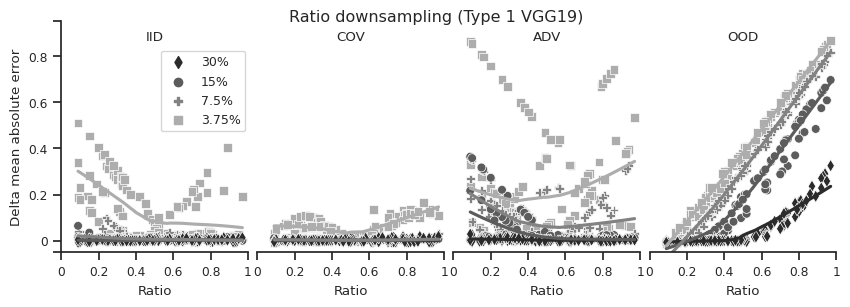

/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


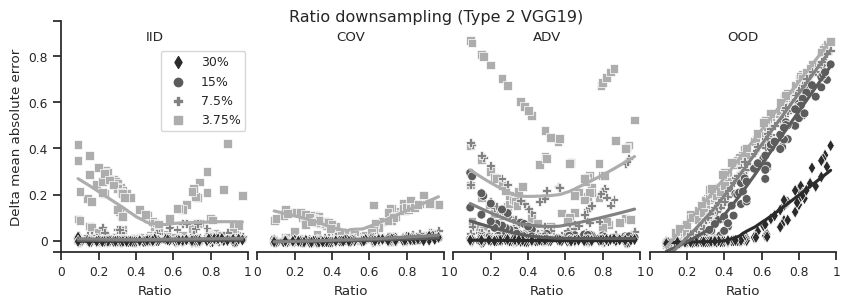

/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


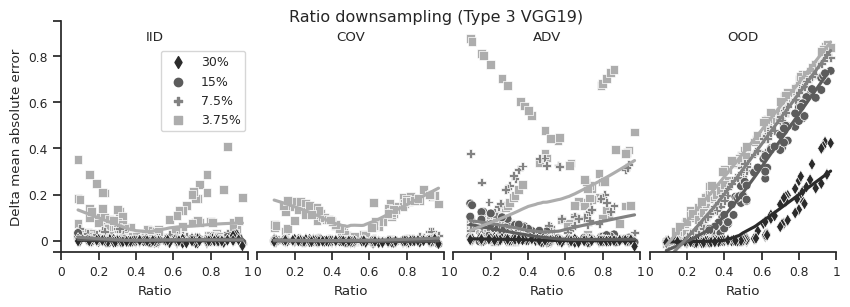

/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


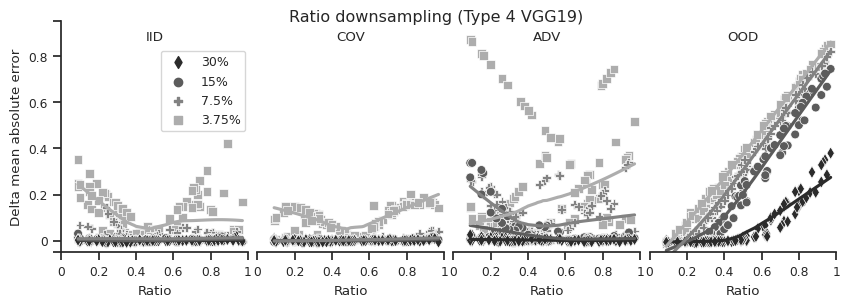

/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


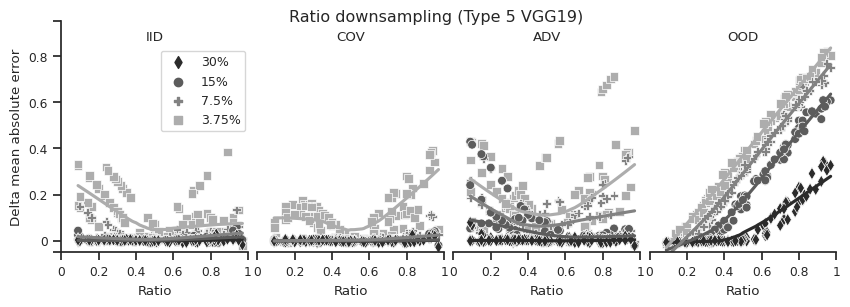

/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


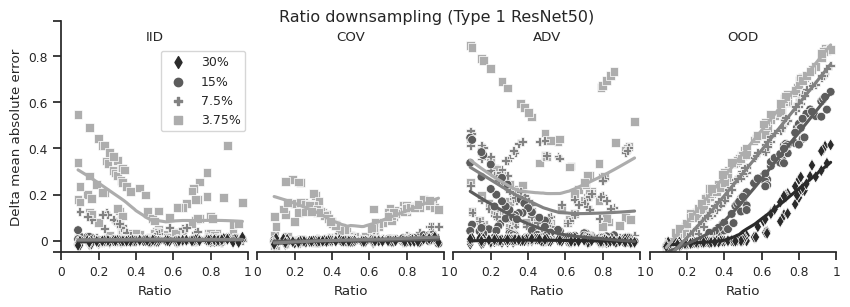

/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


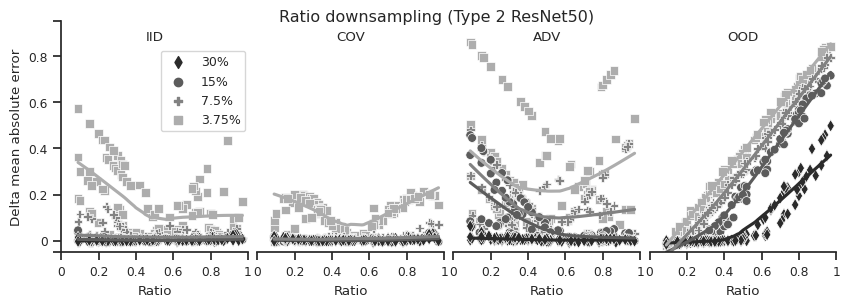

/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


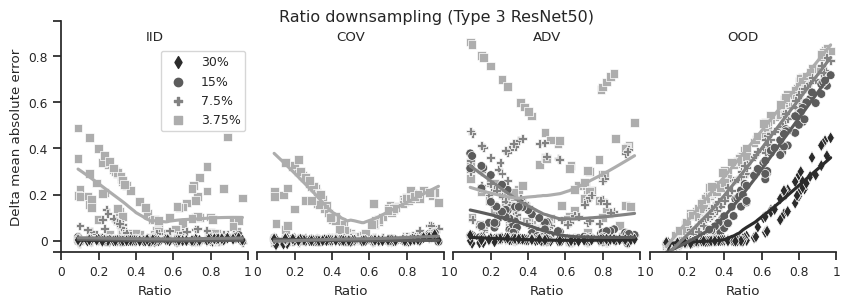

/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


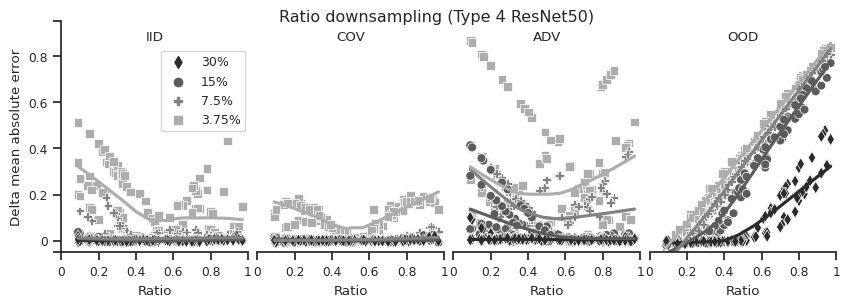

/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/11521364.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


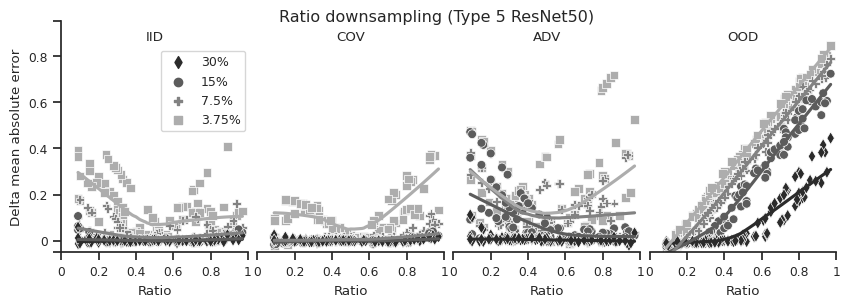

In [88]:
#################### Study II downsample Ratio in training ####################

sns.set(font_scale=0.8)
sns.set_style("ticks")

reduction = {"1/2": "30%", "1/4": "15%", "1/8": "7.5%", "1/16": "3.75%"}
# linestyles = {'IID':'dashed','COV':'dotted','ADV':'solid','OOD':'dashdot'}
colorP = {"IID": "Oranges", "COV": "Greens", "ADV": "Blues", "OOD": "Reds"}

# df_ratio = df_S2ratio.copy()
# df_ratio['Ratio'] = round(df_ratio['RawRatio'], 2) ### round to 0.01 level

for model in ["VGG", "ResNet"]:
    df_ratio = cnn[(cnn.Exp == "Ratio") & (cnn.Model == model)].copy()
    for tp in [1, 2, 3, 4, 5]:  # , 'length'
        # only IID has baseline
        df_base = df_ratio[
            (df_ratio["Type"] == tp)
            & (df_ratio["Level"] == 1)
            & (df_ratio["Method"] == "IID")
        ]
        # df_base = df_base.groupby(['LevelName', 'Run', 'Ratio'])['absError'].mean().reset_index()

        fig, ax = plt.subplots(ncols=4, figsize=(10, 3))

        for idx, method in enumerate(["IID", "COV", "ADV", "OOD"]):
            df_down = df_ratio[
                (df_ratio["Type"] == tp)
                & (df_ratio["Method"] == method)
                & (df_ratio["Level"] != 1)
            ]
            # df_down = df_down.groupby(['LevelName', 'Run', 'Ratio'])['absError'].mean().reset_index()

            # df_down = df_down.append(df_base)
            df_down = pd.concat([df_down, df_base])
            df_pivot = pd.pivot_table(
                data=df_down,
                index=["Run", "Ratio"],
                columns="Level",
                values="absError",
                aggfunc="mean",
            ).reset_index()
            # raise
            # build a dataframe
            res = []
            for i, row in df_pivot.iterrows():
                res.append([row["Run"], row["Ratio"], "30%", 0, row[2] - row[1]])
                res.append([row["Run"], row["Ratio"], "15%", 1, row[4] - row[1]])
                res.append([row["Run"], row["Ratio"], "7.5%", 2, row[8] - row[1]])
                res.append([row["Run"], row["Ratio"], "3.75%", 3, row[16] - row[1]])
            df_plot = pd.DataFrame(
                data=res, columns=["Run", "Ratio", "LevelName", "order", "diff"]
            )
            df_plot.sort_values("order", ascending=False, inplace=True)
            # break
            # break
            # """
            # raise

            # g = sns.lineplot(
            #     x="Ratio",
            #     y="diff",
            #     hue="LevelName",
            #     data=df_plot,
            #     palette="Greys",
            #     ax=ax[idx],
            # )  # colorP[method]
            g = sns.scatterplot(
                data=df_plot,
                x="Ratio",
                y="diff",
                hue="LevelName",
                hue_order=["30%", "15%", "7.5%", "3.75%"],
                style="LevelName",
                style_order=["30%", "15%", "7.5%", "3.75%"],
                markers=["d", "o", "P", "s"],
                palette=grey6r,
                # color=grey6[idx],
                ax=ax[idx],
                s=40,
            )
            for hue_idx, hue in enumerate(["30%", "15%", "7.5%", "3.75%"]):
                sns.regplot(
                    data=df_plot[df_plot.LevelName == hue],
                    x="Ratio",
                    y="diff",
                    color=grey6r[hue_idx],
                    lowess=True,
                    # label=False,
                    scatter=False,
                    ax=ax[idx],
                )

            g.set(xlim=(0, 1))
            g.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            if idx == 0:
                g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
            else:
                g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
            g.set(ylim=(-0.05, 0.95))
            g.set_ylabel("")
            g.set_xlabel("Ratio")

            if idx == 0:
                g.set_yticks([-0.05, 0, 0.2, 0.4, 0.6, 0.8, 0.95])
                g.set_yticklabels(["", "0", "0.2", "0.4", "0.6", "0.8", ""])
                g.set_ylabel("Delta mean absolute error")
                ax[idx].legend(fontsize=9, bbox_to_anchor=(1.02, 0.9))
            else:
                ax[idx].set_yticklabels("")
                ax[idx].yaxis.set_ticks_position("none")
                ax[idx].spines["left"].set_visible(False)
                ax[idx].legend_.remove()

            g.set_title(method, y=0.88)
            # g.set_xlabel(method)
            ax[idx].spines["right"].set_visible(False)
            ax[idx].spines["top"].set_visible(False)

        plt.suptitle(
            f"Ratio downsampling (Type {tp} {'VGG19' if 'VGG' in model else 'ResNet50'})",
            y=0.92,
        )
        plt.subplots_adjust(wspace=0.05)

        # fname = "s2Ratio%sgrey.pdf" % (tp[0].upper())
        # plt.savefig(osp.join(figure_path, fname), format="pdf", bbox_inches="tight")
        fname = f"DeltaVsRatio_Type{tp}_{model}.pdf"
        # print(fname)
        plt.savefig(
            f"{figure_path}/DeltaVsRatio/{fname}",
            format="pdf",
            bbox_inches="tight",
        )
        plt.show()
        # """
    # df_pivot

/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


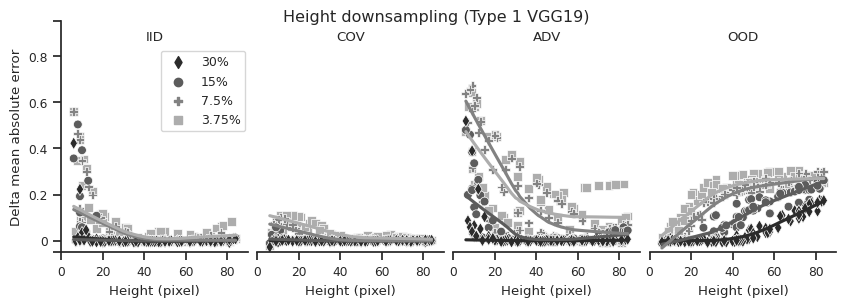

/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


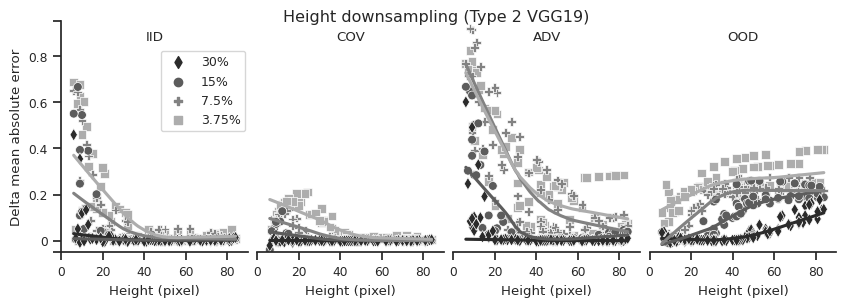

/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


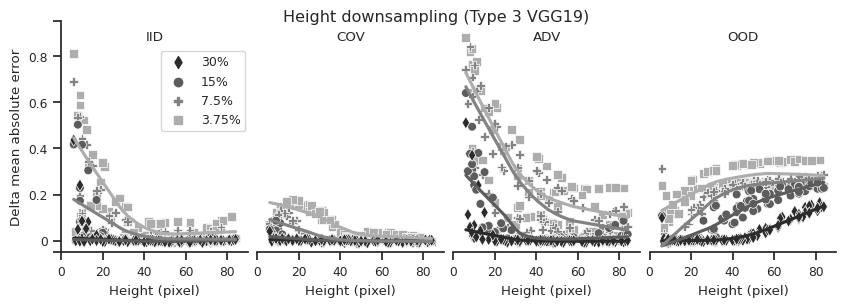

/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


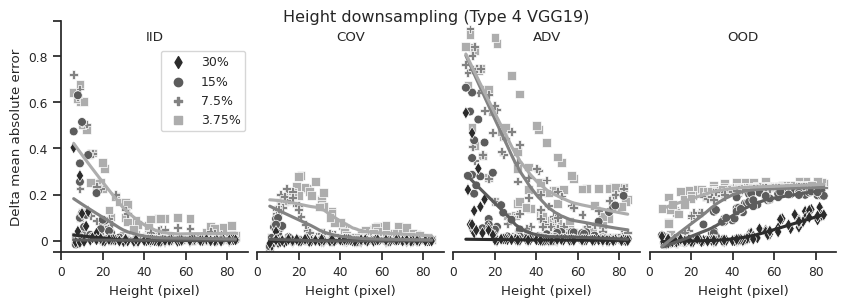

/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


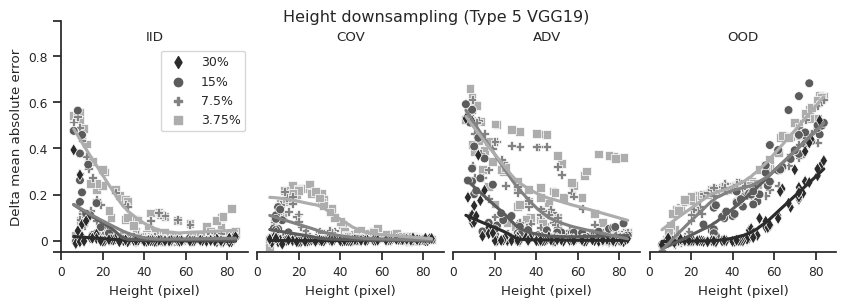

/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


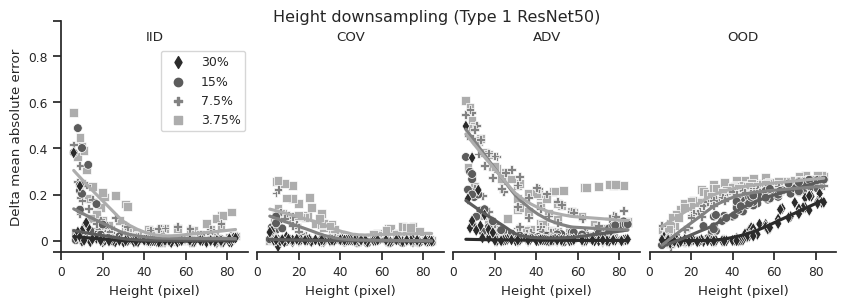

/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


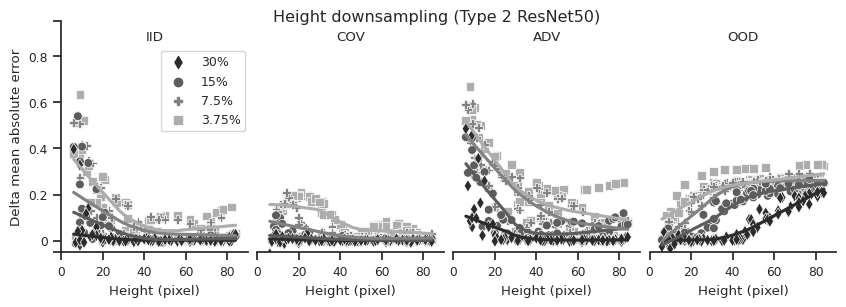

/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


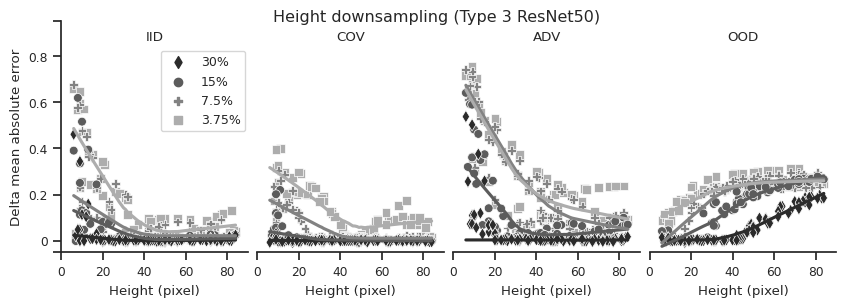

/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


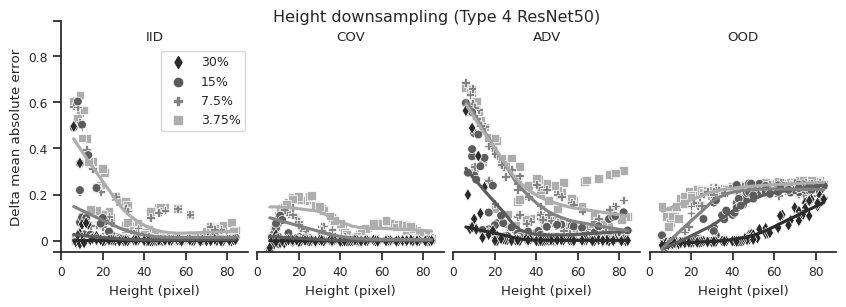

/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_29420/1528359619.py:68: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.scatterplot(


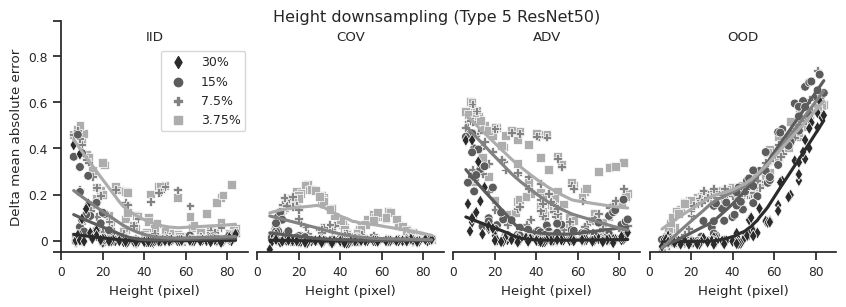

In [91]:
#################### Study II downsample Ratio in training ####################

sns.set(font_scale=0.8)
sns.set_style("ticks")

reduction = {"1/2": "30%", "1/4": "15%", "1/8": "7.5%", "1/16": "3.75%"}
# linestyles = {'IID':'dashed','COV':'dotted','ADV':'solid','OOD':'dashdot'}
colorP = {"IID": "Oranges", "COV": "Greens", "ADV": "Blues", "OOD": "Reds"}

# df_ratio = df_S2ratio.copy()
# df_ratio['Ratio'] = round(df_ratio['RawRatio'], 2) ### round to 0.01 level

for model in ["VGG", "ResNet"]:
    df_ratio = cnn[(cnn.Exp == "Height") & (cnn.Model == model)].copy()
    for tp in [1, 2, 3, 4, 5]:  # , 'length'
        # only IID has baseline
        df_base = df_ratio[
            (df_ratio["Type"] == tp)
            & (df_ratio["Level"] == 1)
            & (df_ratio["Method"] == "IID")
        ]
        # df_base = df_base.groupby(['LevelName', 'Run', 'Ratio'])['absError'].mean().reset_index()

        fig, ax = plt.subplots(ncols=4, figsize=(10, 3))

        for idx, method in enumerate(["IID", "COV", "ADV", "OOD"]):
            df_down = df_ratio[
                (df_ratio["Type"] == tp)
                & (df_ratio["Method"] == method)
                & (df_ratio["Level"] != 1)
            ]
            # df_down = df_down.groupby(['LevelName', 'Run', 'Ratio'])['absError'].mean().reset_index()

            # df_down = df_down.append(df_base)
            df_down = pd.concat([df_down, df_base])
            df_pivot = pd.pivot_table(
                data=df_down,
                index=["Run", "H"],
                columns="Level",
                values="absError",
                aggfunc="mean",
            ).reset_index()
            # raise
            # build a dataframe
            res = []
            for i, row in df_pivot.iterrows():
                res.append([row["Run"], row["H"], "30%", 0, row[2] - row[1]])
                res.append([row["Run"], row["H"], "15%", 1, row[4] - row[1]])
                res.append([row["Run"], row["H"], "7.5%", 2, row[8] - row[1]])
                res.append([row["Run"], row["H"], "3.75%", 3, row[16] - row[1]])
            df_plot = pd.DataFrame(
                data=res, columns=["Run", "H", "LevelName", "order", "diff"]
            )
            df_plot.sort_values("order", ascending=False, inplace=True)
            # break
            # break
            # """
            # raise

            # g = sns.lineplot(
            #     x="H",
            #     y="diff",
            #     hue="LevelName",
            #     data=df_plot,
            #     palette="Greys",
            #     ax=ax[idx],
            # )  # colorP[method]
            g = sns.scatterplot(
                data=df_plot,
                x="H",
                y="diff",
                hue="LevelName",
                hue_order=["30%", "15%", "7.5%", "3.75%"],
                style="LevelName",
                style_order=["30%", "15%", "7.5%", "3.75%"],
                markers=["d", "o", "P", "s"],
                palette=grey6r,
                # color=grey6[idx],
                ax=ax[idx],
                s=40,
            )
            for hue_idx, hue in enumerate(["30%", "15%", "7.5%", "3.75%"]):
                sns.regplot(
                    data=df_plot[df_plot.LevelName == hue],
                    x="H",
                    y="diff",
                    color=grey6r[hue_idx],
                    lowess=True,
                    # label=False,
                    scatter=False,
                    ax=ax[idx],
                )

            g.set(xlim=(0, 90))
            g.set_xticks([0, 20, 40, 60, 80])
            # if idx == 0:
            #     g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
            # else:
            #     g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
            g.set(ylim=(-0.05, 0.95))
            g.set_ylabel("")
            g.set_xlabel("Height (pixel)")

            if idx == 0:
                g.set_yticks([-0.05, 0, 0.2, 0.4, 0.6, 0.8, 0.95])
                g.set_yticklabels(["", "0", "0.2", "0.4", "0.6", "0.8", ""])
                g.set_ylabel("Delta mean absolute error")
                ax[idx].legend(fontsize=9, bbox_to_anchor=(1.02, 0.9))
            else:
                ax[idx].set_yticklabels("")
                ax[idx].yaxis.set_ticks_position("none")
                ax[idx].spines["left"].set_visible(False)
                ax[idx].legend_.remove()

            g.set_title(method, y=0.88)
            # g.set_xlabel(method)
            ax[idx].spines["right"].set_visible(False)
            ax[idx].spines["top"].set_visible(False)

        plt.suptitle(
            f"Height downsampling (Type {tp} {'VGG19' if 'VGG' in model else 'ResNet50'})",
            y=0.92,
        )
        plt.subplots_adjust(wspace=0.05)

        # fname = "s2Ratio%sgrey.pdf" % (tp[0].upper())
        # plt.savefig(osp.join(figure_path, fname), format="pdf", bbox_inches="tight")
        fname = f"DeltaVsHeight_Type{tp}_{model}.pdf"
        # print(fname)
        plt.savefig(
            f"{figure_path}/DeltaVsHeight/{fname}",
            format="pdf",
            bbox_inches="tight",
        )
        plt.show()
        # """
    # df_pivot

## Feature Point plots

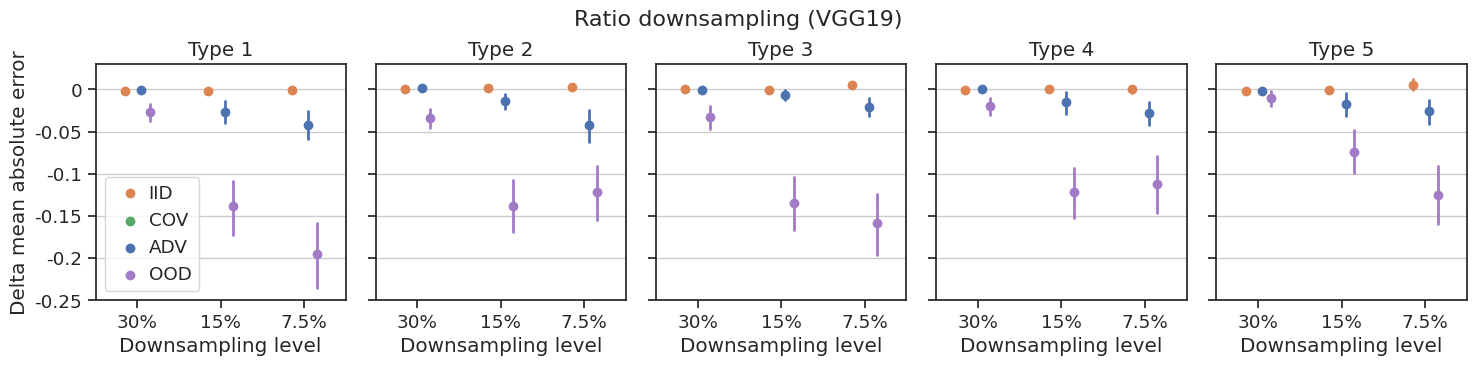

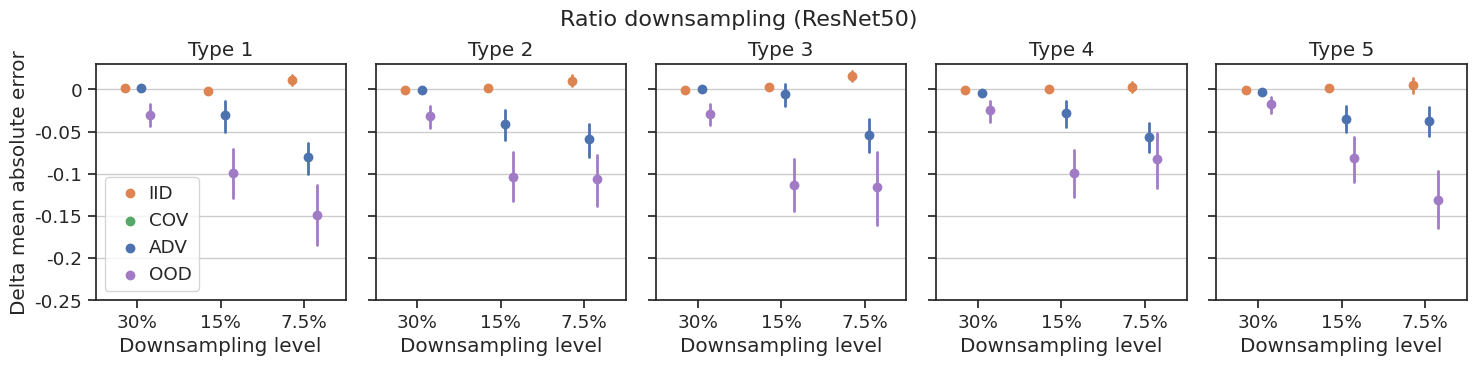

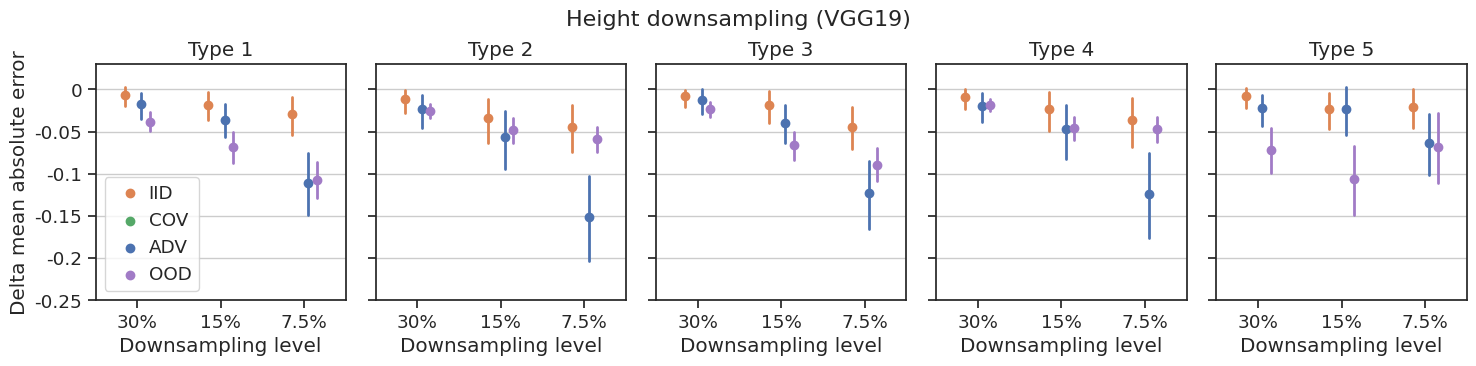

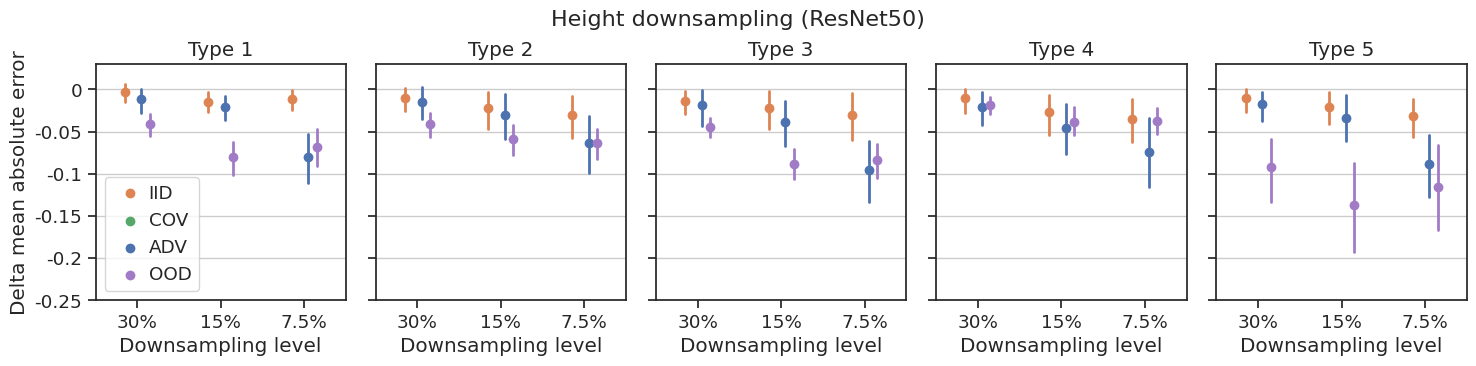

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("ticks", rc={"lines.linewidth": 0.1})


for exp in exps:
    for model in ["VGG", "ResNet"]:
        fig, axes = plt.subplots(1, 5, figsize=(15, 4.0), sharey=True)
        df_load = (
            cnn_feature[
                (cnn_feature.Exp == exp)
                & (cnn_feature.Level.isin([2, 4, 8]))
                & (cnn_feature.Model == model)
            ]
            .groupby(
                [
                    "Model",
                    "Run",
                    "Type",
                    "Method",
                    "Level",
                    "Ratio" if exp == "Ratio" else "H",
                    "Feature",
                ]
            )[["absError"]]
            .mean()
            .reset_index()
            .pivot(
                index=[
                    "Model",
                    "Run",
                    "Type",
                    "Method",
                    "Level",
                    "Ratio" if exp == "Ratio" else "H",
                ],
                columns="Feature",
                values="absError",
            )
            .reset_index()
            .dropna()
        )
        df_load["diff"] = df_load["with"] - df_load["without"]
        for bartype in range(1, 6):
            data = df_load[
                (df_load.Method.isin(methods))
                & (df_load.Level.isin([2, 4, 8]))
                & (df_load.Type == bartype)
            ]
            # fig = plt.figure(figsize=(3.5, 3.75))
            ax = axes[bartype - 1]
            ax.grid(True, axis="y")
            sns.pointplot(
                data=data,
                x="Level",
                y="diff",
                hue="Method",
                hue_order=methods,
                palette=color_deep4,
                join=False,
                dodge=0.3,
                scale=0.8,
                # legend=False,
                ax=ax,
            )
            ax.legend().remove()
            ax.set_ylabel("")
            if bartype == 1:
                ax.legend(handletextpad=0, loc="lower left")
                ax.set_ylabel("Delta mean absolute error")
            ax.set_xticklabels(["30%", "15%", "7.5%"])
            ax.set_title(
                f"Type {bartype}",
                y=1.0,
                # x=0.4 if exp == "Ratio" else 0.37,
                # fontsize=12,
            )
            ax.set_ylim(-0.25, 0.03)
            # ax.set_yticklabels(["0", 0.1, 0.2, 0.3, 0.4, 0.5])
            ax.set_yticks([-0.25, -0.2, -0.15, -0.1, -0.05, 0])
            ax.set_yticklabels([-0.25, -0.2, -0.15, -0.1, -0.05, "0"])
            ax.set_xlabel("Downsampling level")

            lw = ax.lines[0].get_linewidth()  # lw of first line
            plt.setp(ax.lines, linewidth=2)

        plt.suptitle(
            f"{exp} downsampling ({'VGG19' if model == 'VGG' else 'ResNet50'})",
            y=0.92,
            fontsize=16,
        )
        plt.tight_layout()
        plt.savefig(f"{figure_path}/StudyIII{exp}{model}Summary.pdf")
        plt.show()

/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


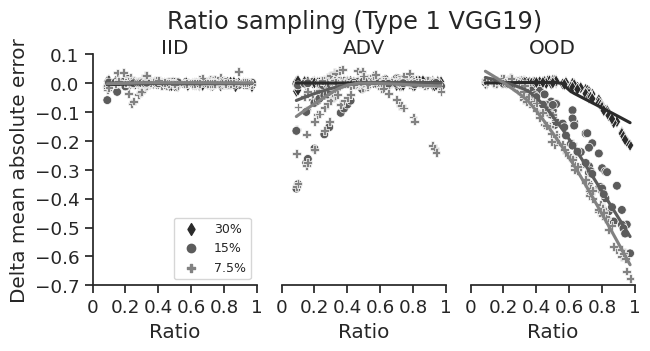

/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


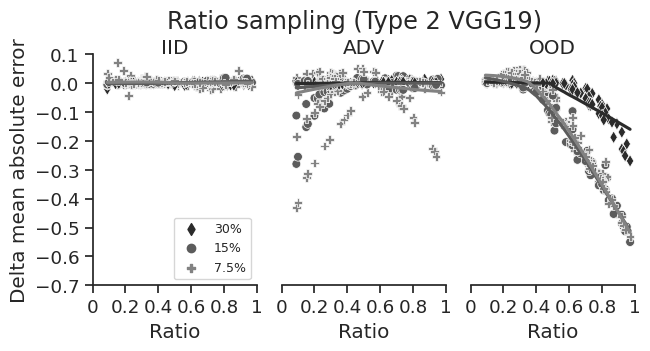

/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


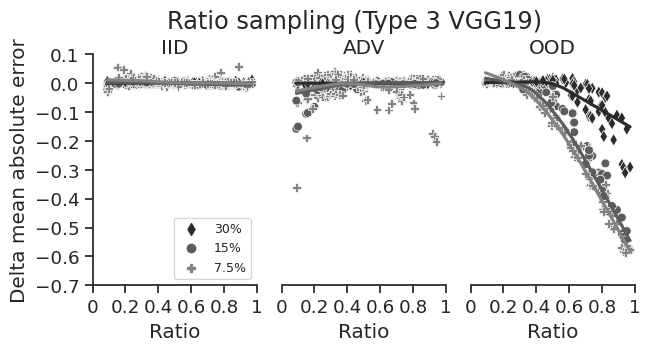

/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


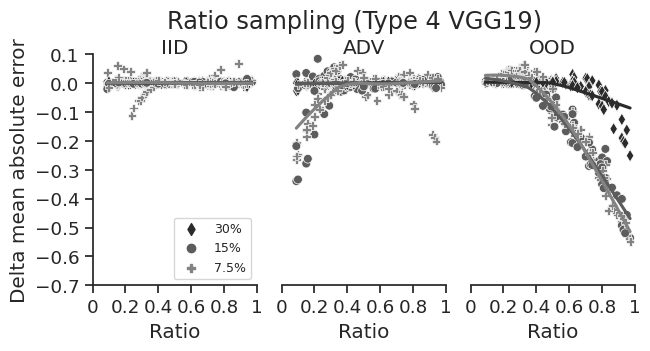

/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


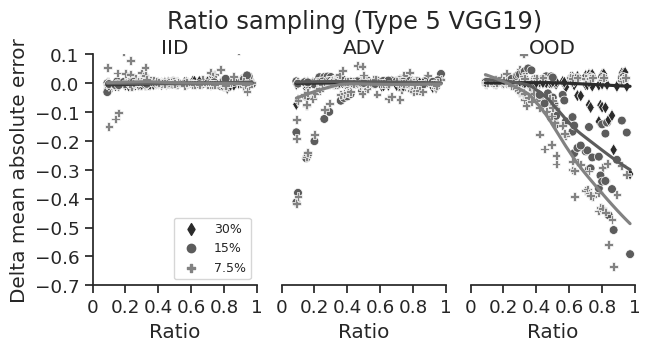

/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


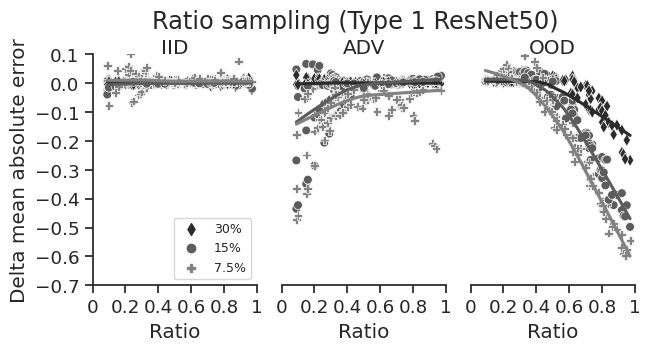

/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


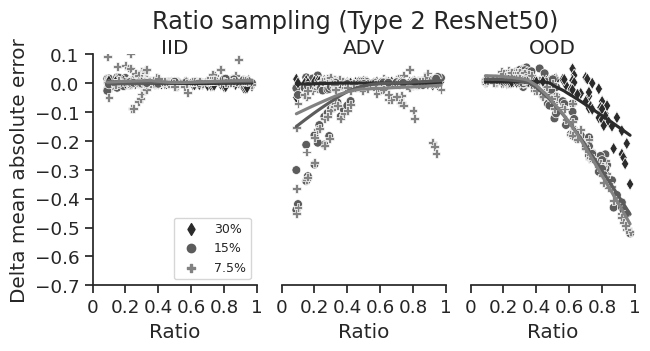

/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


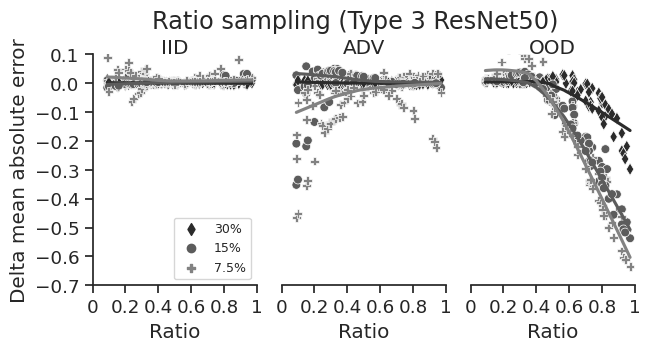

/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


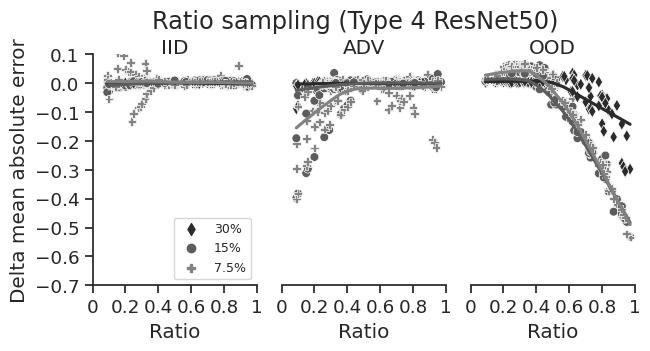

/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/3523986068.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


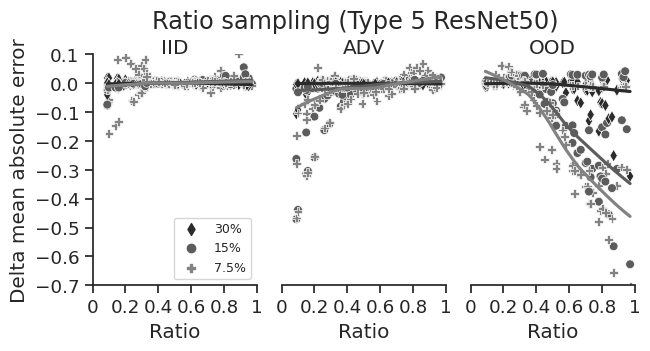

In [9]:
#################### Study III Ratio sampling difference from baseline  #################### by downsample level
sns.set(style="ticks", font_scale=1.2)

df_load = (
    cnn_feature[(cnn_feature.Exp == "Ratio") & (cnn_feature.Level.isin([2, 4, 8]))]
    .groupby(["Model", "Run", "Type", "Method", "Level", "Ratio", "Feature"])[
        ["absError"]
    ]
    .mean()
    .reset_index()
    .pivot(
        index=["Model", "Run", "Type", "Method", "Level", "Ratio"],
        columns="Feature",
        values="absError",
    )
    .reset_index()
    .dropna()
)
df_load["diff"] = df_load["with"] - df_load["without"]

for model in ["VGG", "ResNet"]:
    for bartype in range(1, 6):
        fig, ax = plt.subplots(ncols=3, figsize=(7, 3))  # (7,3)
        for idx, method in enumerate(["IID", "ADV", "OOD"]):
            df_plot = df_load[
                (df_load["Method"] == method)
                & (df_load.Model == model)
                & (df_load.Type == bartype)
            ].copy()
            df_plot.loc[df_plot["Level"] == 2, "newLevel"] = "30%"
            df_plot.loc[df_plot["Level"] == 4, "newLevel"] = "15%"
            df_plot.loc[df_plot["Level"] == 8, "newLevel"] = "7.5%"
            # df_plot.sort_values('Level', ascending=False, inplace=True)

            # g = sns.lineplot(
            #     x="Ratio",
            #     y="diff",
            #     hue="newLevel",
            #     hue_order=["7.5%", "15%", "30%"],
            #     data=df_plot,
            #     palette=grey_3cols,
            #     ax=ax[idx],
            # )
            g = sns.scatterplot(
                data=df_plot,
                x="Ratio",
                y="diff",
                hue="newLevel",
                hue_order=["30%", "15%", "7.5%"],
                style="newLevel",
                style_order=["30%", "15%", "7.5%"],
                markers=["d", "o", "P"],
                palette=grey6r,
                # color=grey6[idx],
                ax=ax[idx],
                s=40,
            )
            for hue_idx, hue in enumerate(["30%", "15%", "7.5%"]):
                sns.regplot(
                    data=df_plot[df_plot.newLevel == hue],
                    x="Ratio",
                    y="diff",
                    color=grey6r[hue_idx],
                    lowess=True,
                    # label=False,
                    scatter=False,
                    ax=ax[idx],
                )

            g.set(xlim=(0, 1))
            g.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            g.set_xlabel("Ratio")
            g.set(ylim=(-0.7, 0.1))
            g.set_ylabel("")
            if idx == 0:
                g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
                g.set_yticks([-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1])
                # g.set_yticklabels(['', '-0.6', '-0.4', '-0.2', '0', ''])
                g.set_ylabel("Delta mean absolute error")
                ax[idx].legend(fontsize=9, loc="lower right")
            else:
                g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
                ax[idx].set_yticklabels("")
                ax[idx].yaxis.set_ticks_position("none")
                ax[idx].spines["left"].set_visible(False)
                ax[idx].legend_.remove()

            g.set_title(method, y=0.97)
            ax[idx].spines["right"].set_visible(False)
            ax[idx].spines["top"].set_visible(False)
        model_name = "VGG19" if "VGG" in model else "ResNet50"
        plt.suptitle(f"Ratio sampling (Type {bartype} {model_name})", y=1.03)
        plt.subplots_adjust(wspace=0.15)

        fname = f"DeltaFeatureVsRatio_Type{bartype}_{model}.pdf"
        plt.savefig(
            f"{figure_path}/DeltaFeatureVsRatio/{fname}",
            format="pdf",
            bbox_inches="tight",
        )
        plt.show()

/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


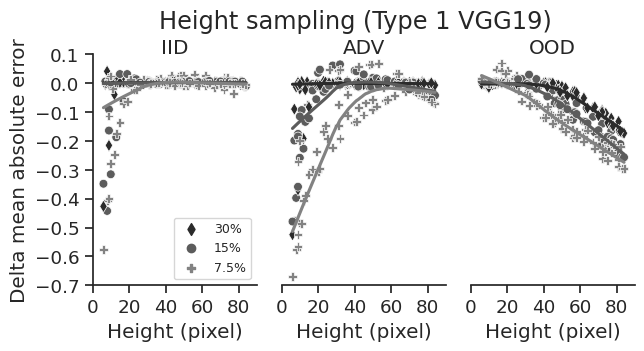

/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


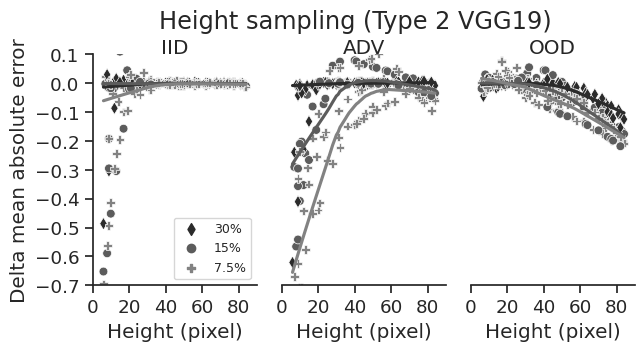

/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


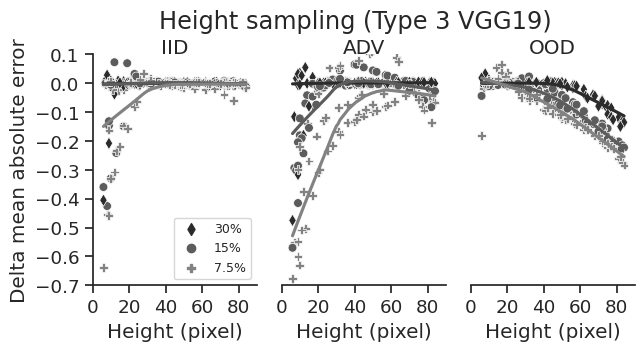

/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


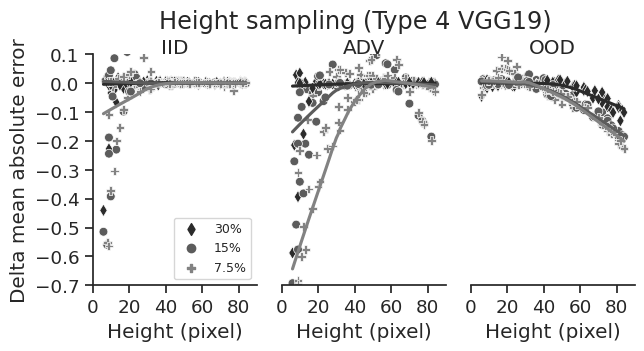

/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


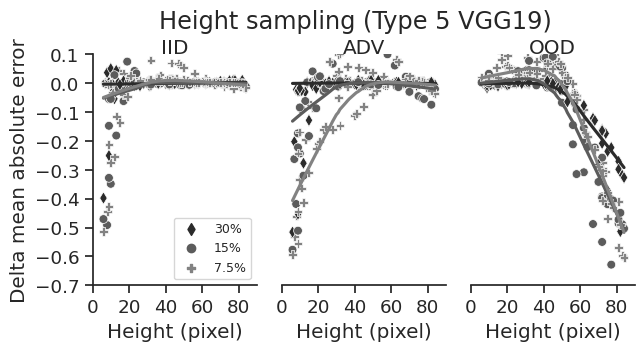

/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


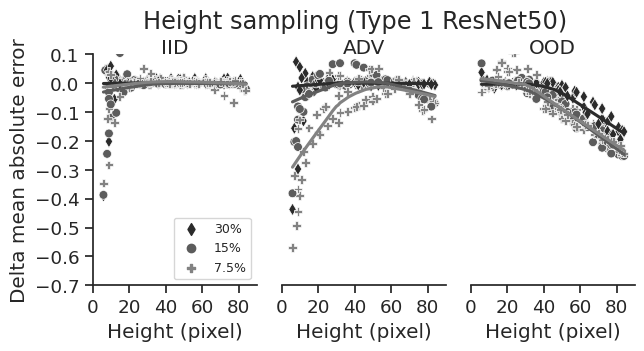

/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


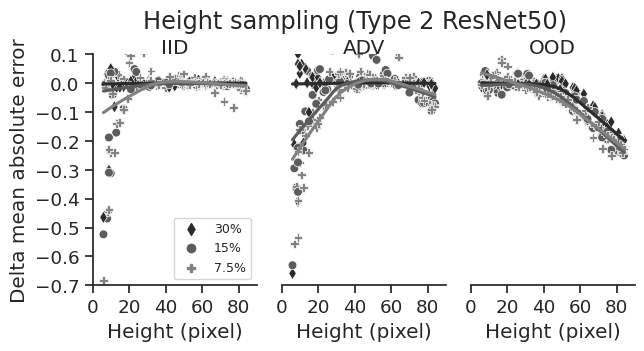

/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


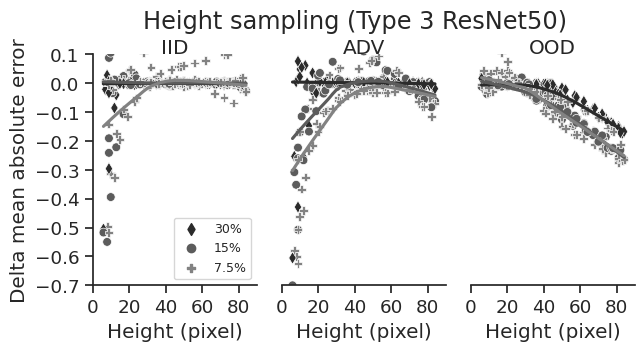

/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


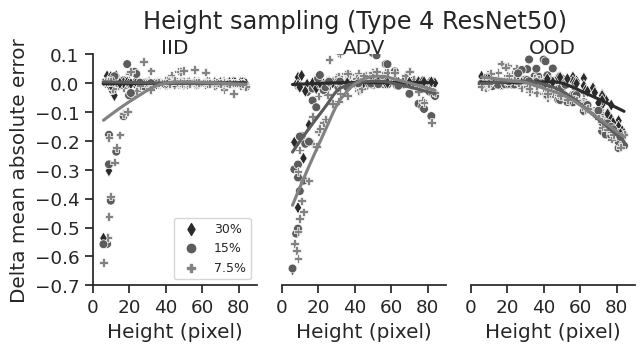

/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(
/tmp/ipykernel_19021/2917129074.py:42: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.scatterplot(


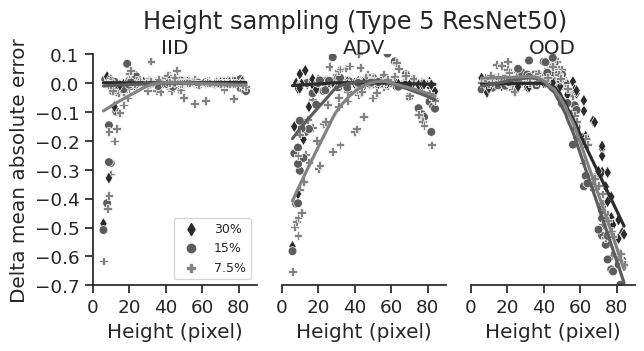

In [10]:
#################### Study III Ratio sampling difference from baseline  #################### by downsample level
sns.set(style="ticks", font_scale=1.2)

df_load = (
    cnn_feature[(cnn_feature.Exp == "Height") & (cnn_feature.Level.isin([2, 4, 8]))]
    .groupby(["Model", "Run", "Type", "Method", "Level", "H", "Feature"])[["absError"]]
    .mean()
    .reset_index()
    .pivot(
        index=["Model", "Run", "Type", "Method", "Level", "H"],
        columns="Feature",
        values="absError",
    )
    .reset_index()
    .dropna()
)
df_load["diff"] = df_load["with"] - df_load["without"]

for model in ["VGG", "ResNet"]:
    for bartype in range(1, 6):
        fig, ax = plt.subplots(ncols=3, figsize=(7, 3))  # (7,3)
        for idx, method in enumerate(["IID", "ADV", "OOD"]):
            df_plot = df_load[
                (df_load["Method"] == method)
                & (df_load.Model == model)
                & (df_load.Type == bartype)
            ].copy()
            df_plot.loc[df_plot["Level"] == 2, "newLevel"] = "30%"
            df_plot.loc[df_plot["Level"] == 4, "newLevel"] = "15%"
            df_plot.loc[df_plot["Level"] == 8, "newLevel"] = "7.5%"
            # df_plot.sort_values('Level', ascending=False, inplace=True)

            # g = sns.lineplot(
            #     x="H",
            #     y="diff",
            #     hue="newLevel",
            #     hue_order=["7.5%", "15%", "30%"],
            #     data=df_plot,
            #     palette=grey_3cols,
            #     ax=ax[idx],
            # )
            g = sns.scatterplot(
                data=df_plot,
                x="H",
                y="diff",
                hue="newLevel",
                hue_order=["30%", "15%", "7.5%"],
                style="newLevel",
                style_order=["30%", "15%", "7.5%"],
                markers=["d", "o", "P"],
                palette=grey6r,
                # color=grey6[idx],
                ax=ax[idx],
                s=40,
            )
            for hue_idx, hue in enumerate(["30%", "15%", "7.5%"]):
                sns.regplot(
                    data=df_plot[df_plot.newLevel == hue],
                    x="H",
                    y="diff",
                    color=grey6r[hue_idx],
                    lowess=True,
                    # label=False,
                    scatter=False,
                    ax=ax[idx],
                )

            g.set(xlim=(0, 90))
            g.set_xticks([0, 20, 40, 60, 80])
            g.set_xlabel("Height (pixel)")
            g.set(ylim=(-0.7, 0.1))
            g.set_ylabel("")
            if idx == 0:
                # g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
                g.set_yticks([-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1])
                # g.set_yticklabels(['', '-0.6', '-0.4', '-0.2', '0', ''])
                g.set_ylabel("Delta mean absolute error")
                ax[idx].legend(fontsize=9, loc="lower right")
            else:
                # g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
                ax[idx].set_yticklabels("")
                ax[idx].yaxis.set_ticks_position("none")
                ax[idx].spines["left"].set_visible(False)
                ax[idx].legend_.remove()

            g.set_title(method, y=0.97)
            ax[idx].spines["right"].set_visible(False)
            ax[idx].spines["top"].set_visible(False)
        model_name = "VGG19" if "VGG" in model else "ResNet50"
        plt.suptitle(f"Height sampling (Type {bartype} {model_name})", y=1.03)
        plt.subplots_adjust(wspace=0.15)

        fname = f"DeltaFeatureVsHeight_Type{bartype}_{model}.pdf"
        plt.savefig(
            f"{figure_path}/DeltaFeatureVsHeight/{fname}",
            format="pdf",
            bbox_inches="tight",
        )
        # plt.savefig(osp.join(figure_path, fname), format='pdf', bbox_inches = 'tight')
        plt.show()

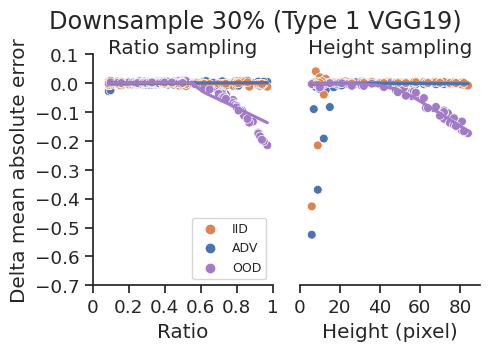

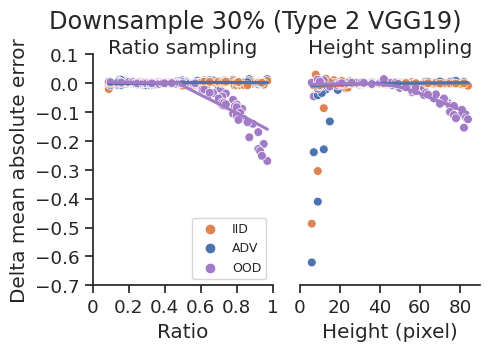

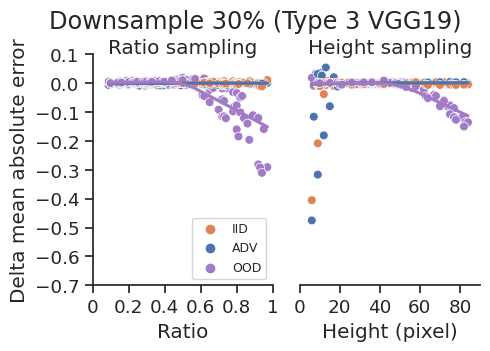

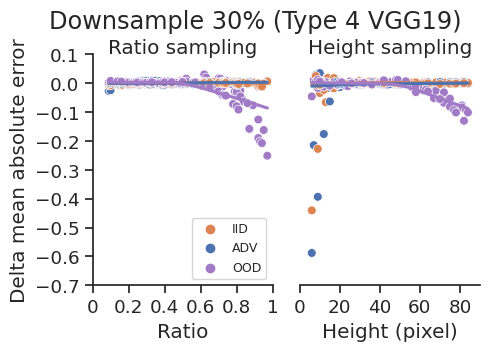

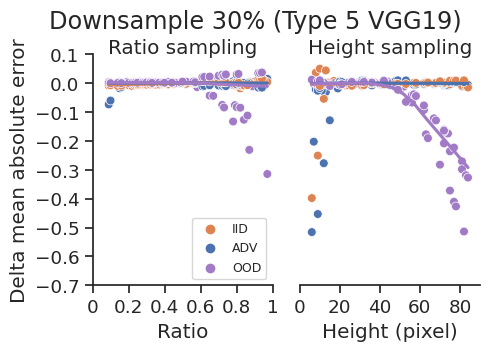

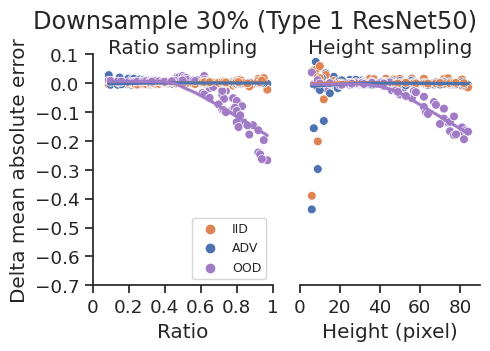

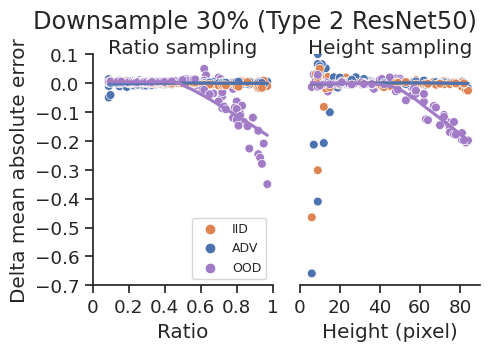

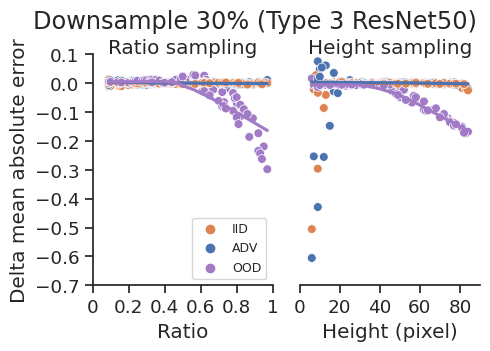

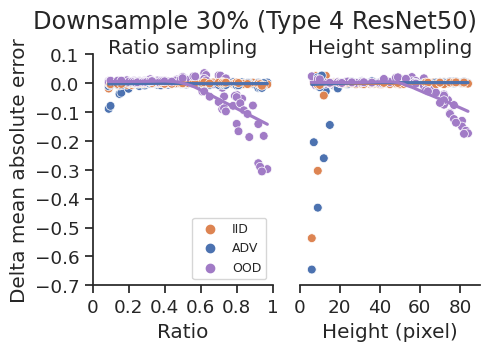

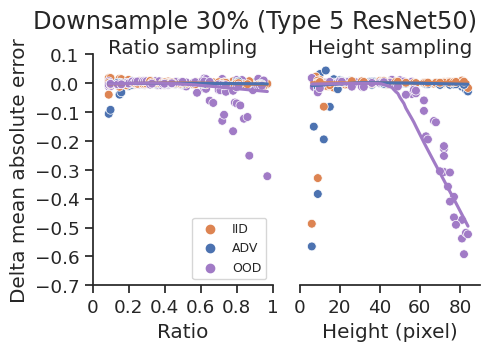

In [16]:
#################### Study III Ratio vs Height distribution shift  #################### ABSOLUTE difference
# Ratio and Height plots side by side
# df_load_R = s3DiffRatio
# df_load_H = s3DiffHeight
sns.set(style="ticks", font_scale=1.2)

for model in ["VGG", "ResNet"]:
    for bartype in range(1, 6):
        fig, ax = plt.subplots(ncols=2, figsize=(5, 3))
        for idx, tp in enumerate(["Ratio", "Height"]):
            if tp == "Height":
                df_load = (
                    cnn_feature[
                        (cnn_feature.Exp == tp)
                        & (cnn_feature.Level.isin([2, 4, 8]))
                        & (cnn_feature.Model == model)
                        & (cnn_feature.Type == bartype)
                    ]
                    .groupby(
                        ["Model", "Run", "Type", "Method", "Level", "H", "Feature"]
                    )[["absError"]]
                    .mean()
                    .reset_index()
                    .pivot(
                        index=["Model", "Run", "Type", "Method", "Level", "H"],
                        columns="Feature",
                        values="absError",
                    )
                    .reset_index()
                    .dropna()
                )
                df_load["diff"] = df_load["with"] - df_load["without"]
                df_plot = df_load[(df_load["Level"] == 2)]
                # g = sns.lineplot(
                #     x="H",
                #     y="diff",
                #     hue="Method",
                #     hue_order=["IID", "ADV", "OOD"],
                #     data=df_plot,
                #     palette=[color_deep4[i] for i in [0, 2, 3]],
                #     ax=ax[idx],
                # )
                g = sns.scatterplot(
                    data=df_plot,
                    x="H",
                    y="diff",
                    hue="Method",
                    hue_order=["IID", "ADV", "OOD"],
                    # style="newLevel",
                    style_order=["30%", "15%", "7.5%"],
                    # markers=["d", "o", "P"],
                    palette=[color_deep4[i] for i in [0, 2, 3]],
                    # color=grey6[idx],
                    ax=ax[idx],
                    s=40,
                )
                for hue_idx, hue in enumerate(["IID", "ADV", "OOD"]):
                    sns.regplot(
                        data=df_plot[df_plot.Method == hue],
                        x="H",
                        y="diff",
                        # color=grey6r[hue_idx],
                        color=[color_deep4[i] for i in [0, 2, 3]][hue_idx],
                        lowess=True,
                        # label=False,
                        scatter=False,
                        ax=ax[idx],
                    )
                g.set(xlim=(0, 90))
                g.set_xticks([0, 20, 40, 60, 80])
                # g.set_xticklabels(["", "10", "30", "50", "70", "90"])
                g.set_xlabel("Height (pixel)")
            else:
                df_load = (
                    cnn_feature[
                        (cnn_feature.Exp == tp)
                        & (cnn_feature.Level.isin([2, 4, 8]))
                        & (cnn_feature.Model == model)
                        & (cnn_feature.Type == bartype)
                    ]
                    .groupby(
                        ["Model", "Run", "Type", "Method", "Level", "Ratio", "Feature"]
                    )[["absError"]]
                    .mean()
                    .reset_index()
                    .pivot(
                        index=["Model", "Run", "Type", "Method", "Level", "Ratio"],
                        columns="Feature",
                        values="absError",
                    )
                    .reset_index()
                    .dropna()
                )
                df_load["diff"] = df_load["with"] - df_load["without"]
                df_plot = df_load[(df_load["Level"] == 2)]
                # g = sns.lineplot(
                #     x="Ratio",
                #     y="diff",
                #     hue="Method",
                #     hue_order=["IID", "ADV", "OOD"],
                #     data=df_plot,
                #     palette=[color_deep4[i] for i in [0, 2, 3]],
                #     ax=ax[idx],
                # )
                g = sns.scatterplot(
                    data=df_plot,
                    x="Ratio",
                    y="diff",
                    hue="Method",
                    hue_order=["IID", "ADV", "OOD"],
                    # style="newLevel",
                    style_order=["30%", "15%", "7.5%"],
                    # markers=["d", "o", "P"],
                    palette=[color_deep4[i] for i in [0, 2, 3]],
                    # color=grey6[idx],
                    ax=ax[idx],
                    s=40,
                )
                for hue_idx, hue in enumerate(["IID", "ADV", "OOD"]):
                    sns.regplot(
                        data=df_plot[df_plot.Method == hue],
                        x="Ratio",
                        y="diff",
                        # color=grey6r[hue_idx],
                        color=[color_deep4[i] for i in [0, 2, 3]][hue_idx],
                        lowess=True,
                        # label=False,
                        scatter=False,
                        ax=ax[idx],
                    )
                g.set(xlim=(0, 1))
                g.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
                g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
                g.set_xlabel("Ratio")

            g.set(ylim=(-0.7, 0.1))
            g.set_ylabel("")

            if idx == 0:
                g.set_yticks([-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1])
                # g.set_yticklabels(['', '-0.6', '-0.4', '-0.2', '0', ''])
                g.set_ylabel("Delta mean absolute error")
                ax[idx].legend(fontsize=9, loc="lower right")
            else:
                ax[idx].set_yticklabels("")
                ax[idx].yaxis.set_ticks_position("none")
                ax[idx].spines["left"].set_visible(False)
                ax[idx].legend_.remove()

            g.set_title(f"{tp} sampling", y=0.97)
            ax[idx].spines["right"].set_visible(False)
            ax[idx].spines["top"].set_visible(False)

        model_name = "VGG19" if model == "VGG" else "ResNet50"
        plt.suptitle(f"Downsample 30% (Type {bartype} {model_name})", y=1.03, x=0.45)
        plt.subplots_adjust(wspace=0.15)

        fname = f"DeltaVsRatioHeight_Level2_Type{bartype}_{model}.pdf"
        plt.savefig(
            f"{figure_path}/DeltaVsRatioHeight_Level2/{fname}",
            format="pdf",
            bbox_inches="tight",
        )
        plt.show()

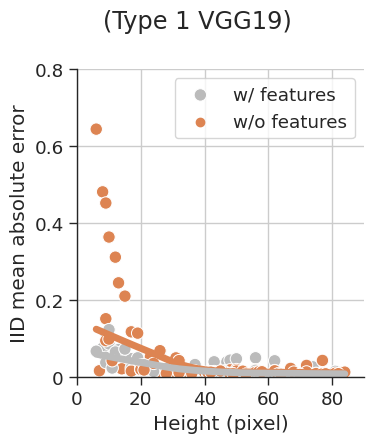

In [24]:
#################### Study III Ratio vs Height distribution shift  #################### ABSOLUTE difference
# Ratio and Height plots side by side
# df_load_R = s3DiffRatio
# df_load_H = s3DiffHeight
sns.set(style="ticks", font_scale=1.2)

for model in ["VGG", "ResNet"][:1]:
    for bartype in range(1, 2):
        fig, ax = plt.subplots(ncols=1, figsize=(3.7, 4))
        ax = [ax]
        for idx, tp in enumerate(["Height", "Ratio"][:1]):
            if tp == "Height":
                df_load = (
                    cnn_feature[
                        (cnn_feature.Exp == tp)
                        & (cnn_feature.Level.isin([2, 4, 8]))
                        & (cnn_feature.Model == model)
                        & (cnn_feature.Type == bartype)
                    ]
                    .groupby(
                        ["Model", "Run", "Type", "Method", "Level", "H", "Feature"]
                    )[["absError"]]
                    .mean()
                    .reset_index()
                    # .pivot(
                    #     index=["Model", "Run", "Type", "Method", "Level", "H"],
                    #     columns="Feature",
                    #     values="absError",
                    # )
                    # .reset_index()
                    .dropna()
                )
                # df_load["diff"] = df_load["with"] - df_load["without"]
                df_plot = df_load[
                    (df_load["Level"] == 8) & (df_load["Method"] == "IID")
                ]
                # g = sns.lineplot(
                #     x="H",
                #     y="diff",
                #     hue="Method",
                #     hue_order=["IID", "ADV", "OOD"],
                #     data=df_plot,
                #     palette=[color_deep4[i] for i in [0, 2, 3]],
                #     ax=ax[idx],
                # )
                g = sns.scatterplot(
                    data=df_plot,
                    x="H",
                    y="absError",
                    hue="Feature",
                    hue_order=["without", "with"],
                    # style="newLevel",
                    # style_order=["30%", "15%", "7.5%"],
                    # markers=["d", "o", "P"],
                    # palette=[color_deep4[i] for i in [0, 2, 3]],
                    # palette=[grey6r[i] for i in [0, 3]],
                    palette=[color_deep4[0], "#bbbbbb"],
                    # color=grey6[idx],
                    ax=ax[idx],
                    s=80,
                )
                for hue_idx, hue in enumerate(["without", "with"]):
                    sns.regplot(
                        data=df_plot[df_plot.Feature == hue],
                        x="H",
                        y="absError",
                        # color=grey6r[hue_idx],
                        # color=[color_deep4[i] for i in [0, 2, 3]][hue_idx],
                        # color=[grey6r[i] for i in [0, 3]][hue_idx],
                        color=[color_deep4[0], "#bbbbbb"][hue_idx],
                        lowess=True,
                        # label=False,
                        scatter=False,
                        ax=ax[idx],
                        line_kws=dict(lw=5),
                    )
                g.set(xlim=(0, 90))
                g.set_xticks([0, 20, 40, 60, 80])
                # g.set_xticklabels(["", "10", "30", "50", "70", "90"])
                g.set_xlabel("Height (pixel)")

            # g.set(ylim=(-0.7, 0.1))
            g.set_ylabel("")

            if idx == 0:
                # g.set_yticks([-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1])
                # g.set_yticklabels(['', '-0.6', '-0.4', '-0.2', '0', ''])
                g.set_ylabel("IID mean absolute error")
                ax[idx].legend(loc="best", labels=["w/ features", "w/o features"])
            else:
                ax[idx].set_yticklabels("")
                ax[idx].yaxis.set_ticks_position("none")
                ax[idx].spines["left"].set_visible(False)
                ax[idx].legend_.remove()

            # g.set_title(f"{tp} sampling", y=0.97)
            for f in ax[idx].spines.values():
                f.set_linewidth(1)
            ax[idx].tick_params(width=1)
            ax[idx].spines["right"].set_visible(False)
            ax[idx].spines["top"].set_visible(False)

        model_name = "VGG19" if model == "VGG" else "ResNet50"
        plt.suptitle(f"(Type {bartype} {model_name})", y=1.03, x=0.45)
        plt.subplots_adjust(wspace=0.15)
        plt.yticks(
            [0, 0.2, 0.4, 0.6, 0.8],
            ["0", 0.2, 0.4, 0.6, 0.8],
        )
        plt.ylim(0, 0.8)
        plt.grid(True)

        fname = f"DeltaVsRatioHeight_Level2_Type{bartype}_{model}.pdf"
        # plt.savefig(
        #     f"{figure_path}/DeltaVsRatioHeight_Level2/{fname}",
        #     format="pdf",
        #     bbox_inches="tight",
        # )
        plt.show()

-0.866430592964859 9.236558708703512e-27


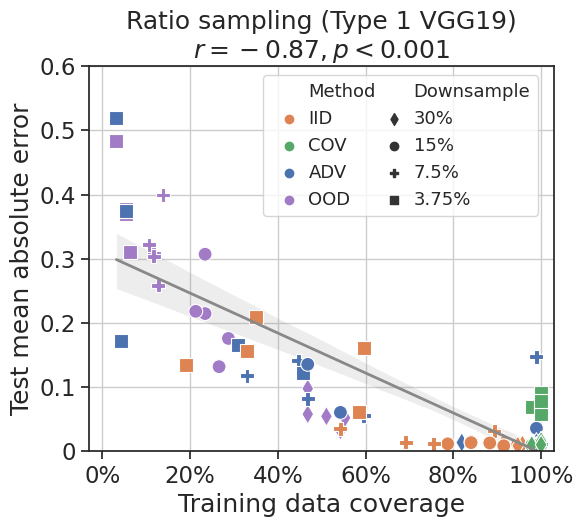

-0.8624678736725118 2.8580176643829984e-26


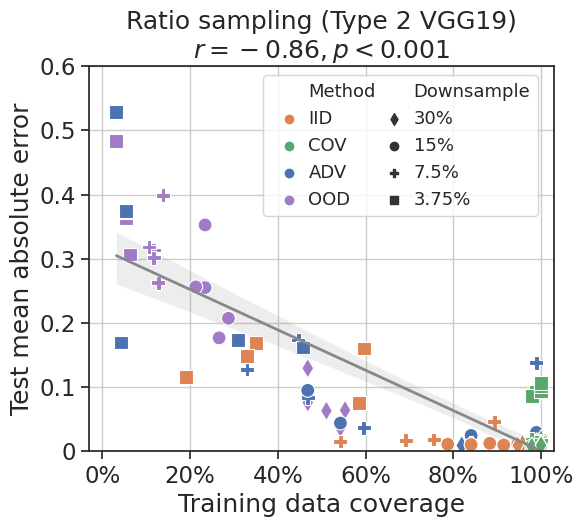

-0.7939547085104612 1.2617632069391744e-19


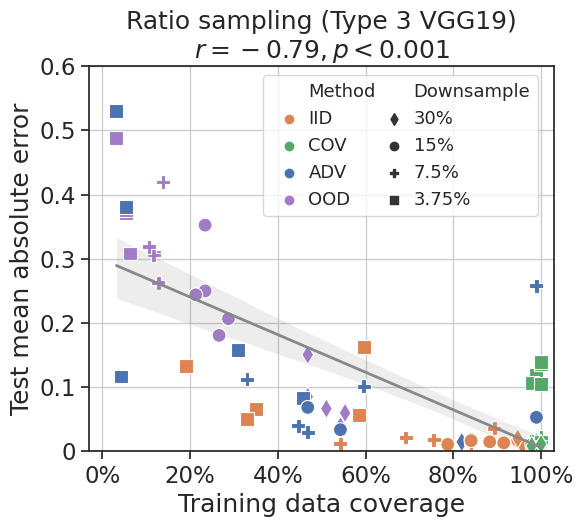

-0.8423541899085802 5.374480122396671e-24


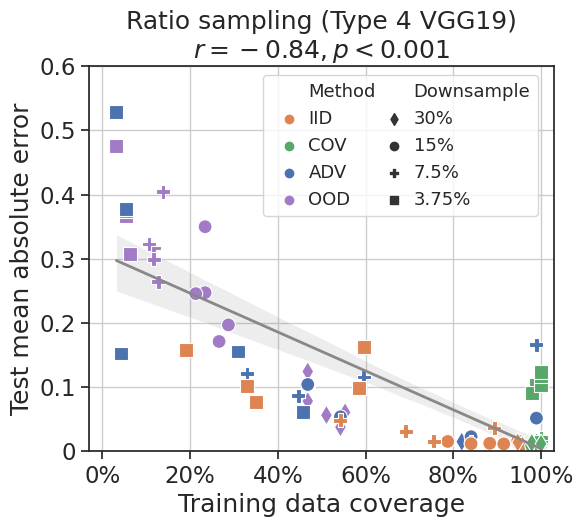

-0.8775894647135095 3.127491945670192e-28


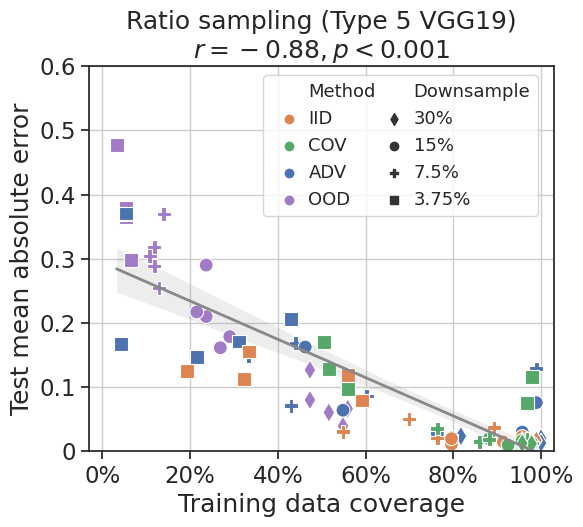

-0.8420128478720915 5.836463094389711e-24


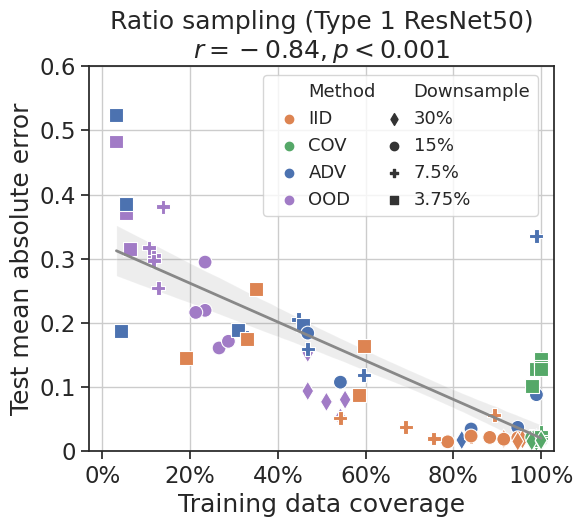

-0.8800382933276037 1.4233211463666757e-28


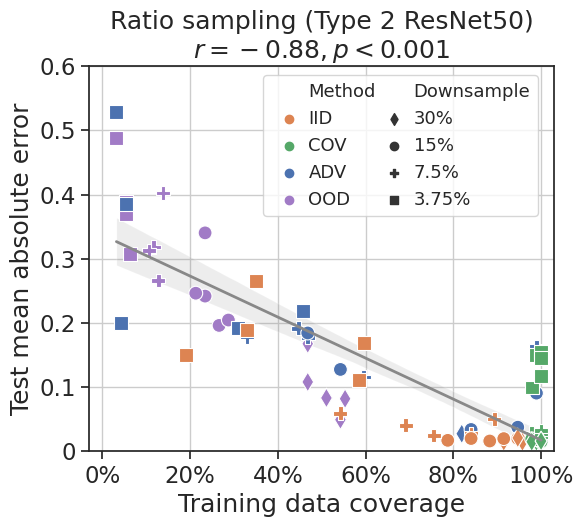

-0.8213666083349026 6.1244281008487e-22


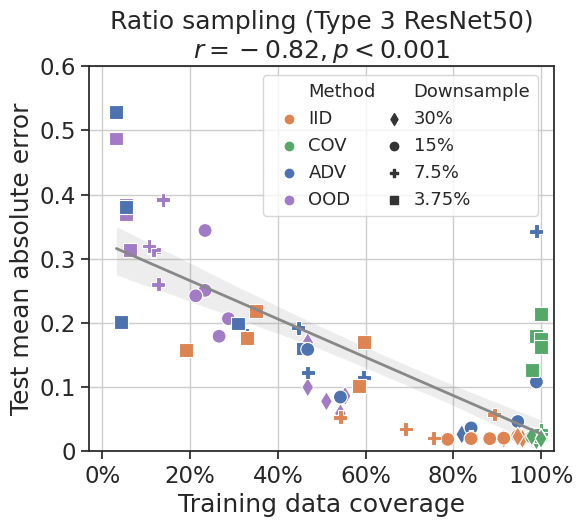

-0.8781990946209067 2.5749630071908526e-28


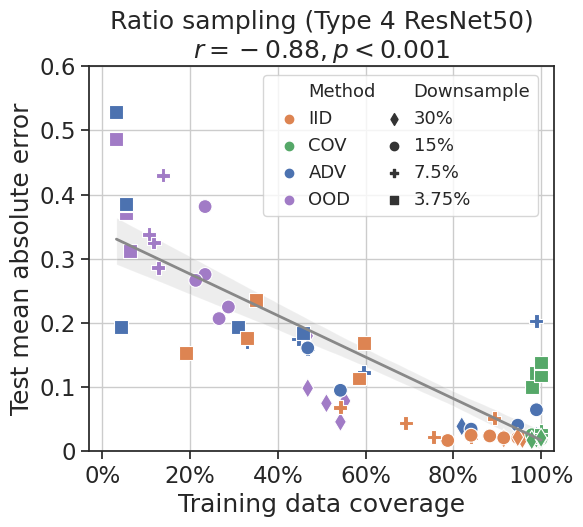

-0.891169478396772 3.157085640848531e-30


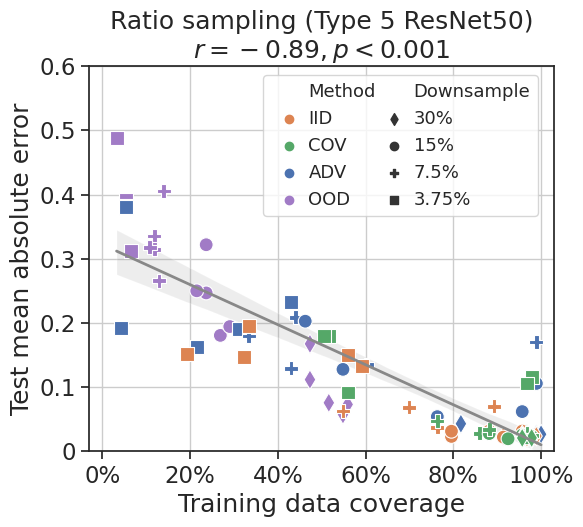

-0.911426800648717 9.326655955051154e-34


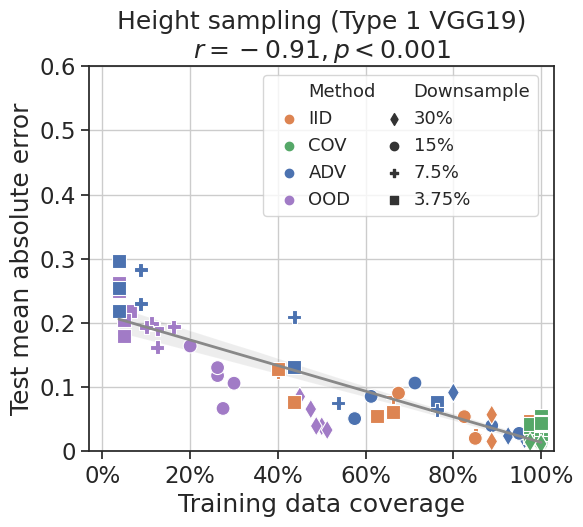

-0.8488970423858642 1.0641059394991463e-24


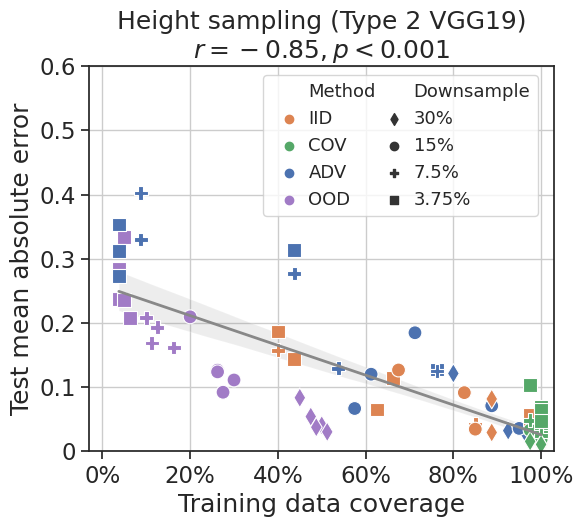

-0.8697257802691989 3.5114838826045686e-27


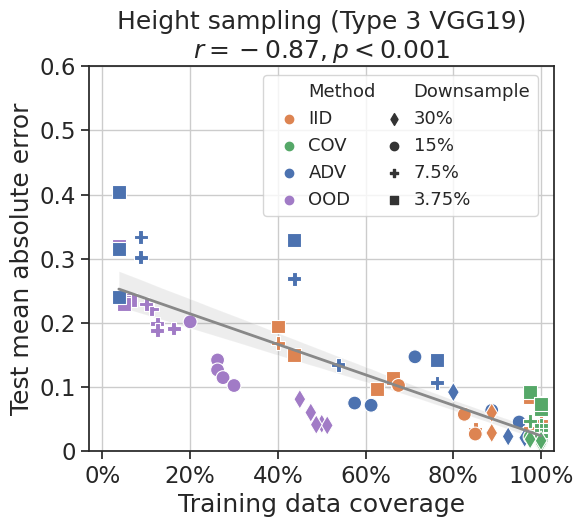

-0.7761002112580687 2.6791131937203596e-18


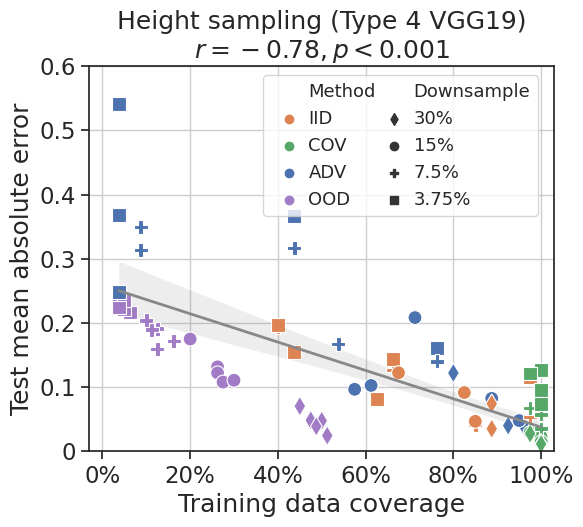

-0.8989723070879198 1.6941158422779407e-31


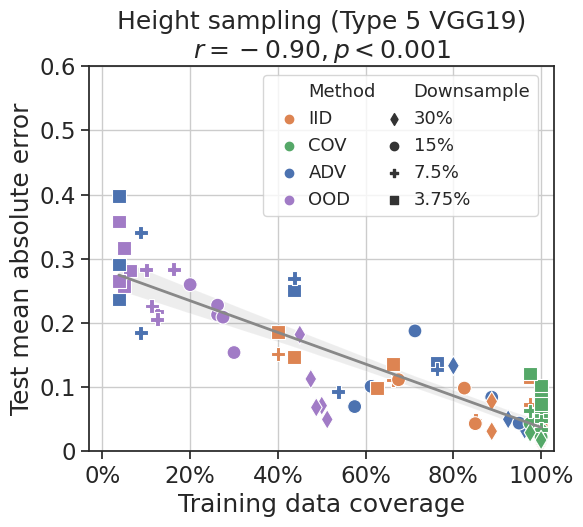

-0.9100854871123605 1.6927211616763612e-33


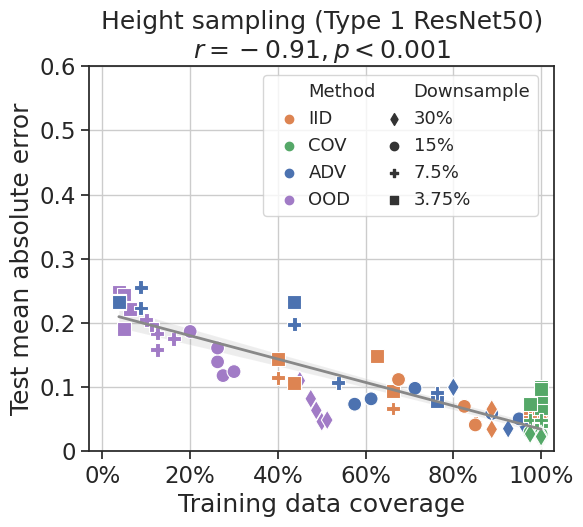

-0.9007913095891732 8.277163591947137e-32


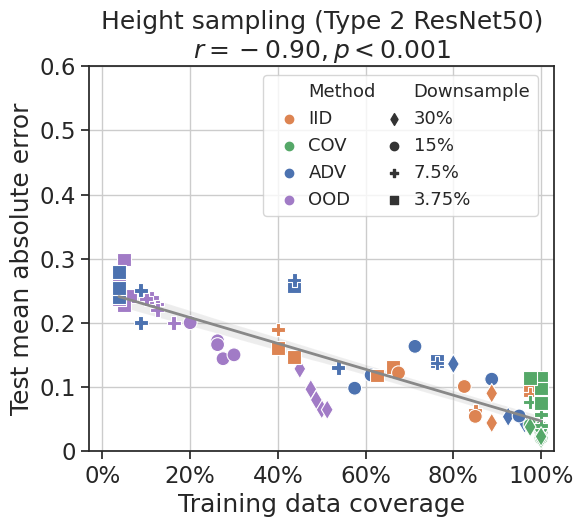

-0.8372496438943536 1.8081083568631578e-23


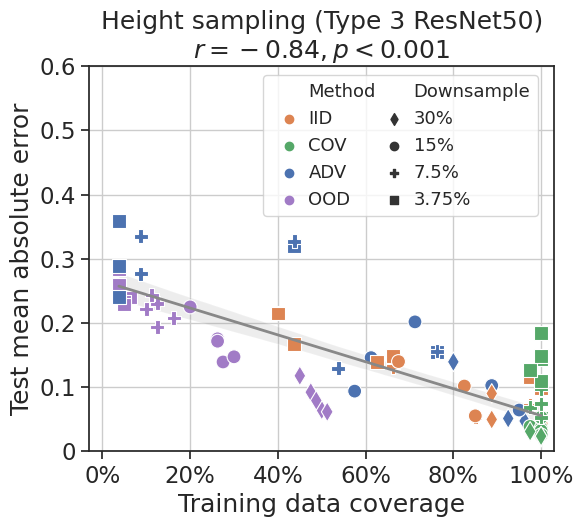

-0.8444918705896237 3.192302945320335e-24


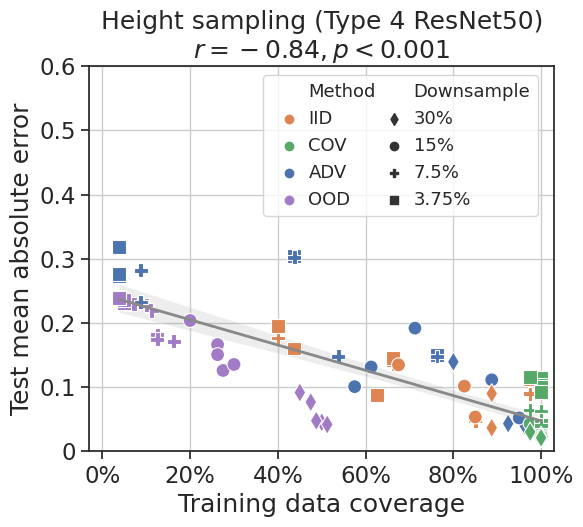

-0.9010939802318366 7.33735169967201e-32


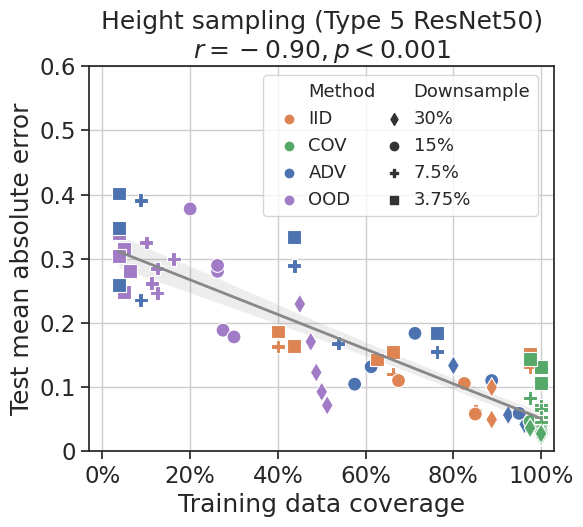

In [ ]:
####### Study II training data coverage map Ratio ----- merge Levels and Types
sns.set(font_scale=1.5)
sns.set_style("ticks")

for exp in ["Ratio", "Height"]:
    for model in ["VGG", "ResNet"]:
        for bartype in range(1, 6):
            # use data previously saved
            # df_range = df_S2ratio.groupby(['Method','TypeName','LevelName','Run','TrainCover'])['absError'].mean().reset_index()
            # df_range = df_range[(df_range['TypeName']=='position') & (df_range['Method']!='ADV_FIX') & (df_range['Method']!='OOD_FIX')]
            df_range = cnn_cover[
                (cnn_cover.Exp == exp)
                & (cnn_cover.Model == model)
                & (cnn_cover.Type == bartype)
                & (cnn_cover.Method.isin(methods))
            ].copy()

            df_range.loc[df_range["Level"] == 2, "Downsample"] = "30%"
            df_range.loc[df_range["Level"] == 4, "Downsample"] = "15%"
            df_range.loc[df_range["Level"] == 8, "Downsample"] = "7.5%"
            df_range.loc[df_range["Level"] == 16, "Downsample"] = "3.75%"

            # put COV on top
            sort_order = ["COV", "IID", "ADV", "OOD"]
            order_dict = {key: i for i, key in enumerate(sort_order)}
            df_range = df_range.sort_values(
                by=["Method"], key=lambda x: x.map(order_dict), ascending=False
            )

            # calculate correlation
            from scipy.stats import pearsonr

            r, p = pearsonr(df_range["TrainCover"], df_range["absError"])
            print(r, p)

            # fig, ax = plt.subplots(figsize=(7,4.5))
            fig, ax = plt.subplots(figsize=(6, 5))

            # add the overall trendline
            g = sns.regplot(
                x="TrainCover",
                y="absError",
                data=df_range,
                scatter_kws={"s": 0},
                line_kws={"lw": 2},
                color="#888888",
                ax=ax,
            )

            g.set(xlim=(-0.03, 1.03))
            g.set(xticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
            g.set_xticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
            g.set(ylim=(0, 0.5))
            g.set(yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
            g.set_yticklabels(["0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6"])
            g.set_xlabel("Training data coverage")  # not set_label
            g.set_ylabel("Test mean absolute error")

            g = sns.scatterplot(
                x="TrainCover",
                y="absError",
                hue="Method",
                hue_order=["IID", "COV", "ADV", "OOD"],
                style="Downsample",
                style_order=["30%", "15%", "7.5%", "3.75%"],
                markers=["d", "o", "P", "s"],
                data=df_range,
                palette=color_deep4,
                # alpha=0.8,
                s=100,
                ax=ax,
            )  ###### use col_wrap=1 for ratio

            h, l = g.axes.get_legend_handles_labels()
            g.axes.legend_.remove()
            g.figure.legend(
                h,
                l,
                ncol=2,
                loc="upper left",
                bbox_to_anchor=(0.4, 0.88),
                handletextpad=0.1,
                columnspacing=0.0,
                fontsize=13,
            )

            model_name = "ResNet50" if model == "ResNet" else "VGG19"
            g.set_title(
                f"{exp} sampling (Type {bartype} {model_name})\n$r={r:.2f}, p<0.001$",
                # fontsize="14",
                x=0.5,
                y=1,
            )  # stat[0]
            plt.grid()

            fname = f"ErrVsCoverage_{exp}_Type{bartype}_{model}.pdf"
            plt.savefig(
                f"{figure_path}/ErrVsCoverage/{fname}",
                format="pdf",
                bbox_inches="tight",
            )
            plt.show()

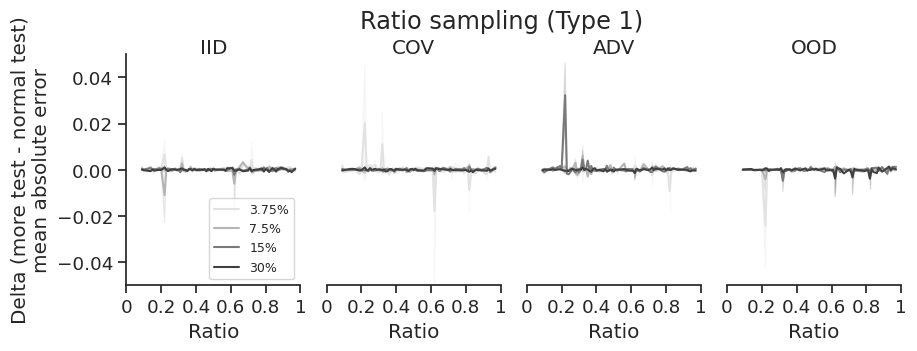

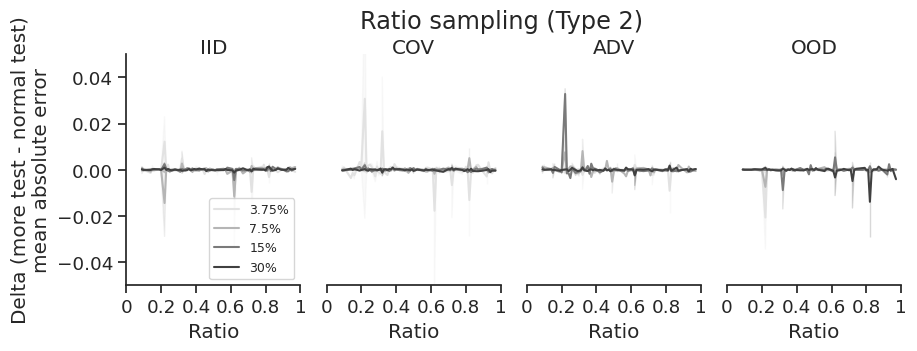

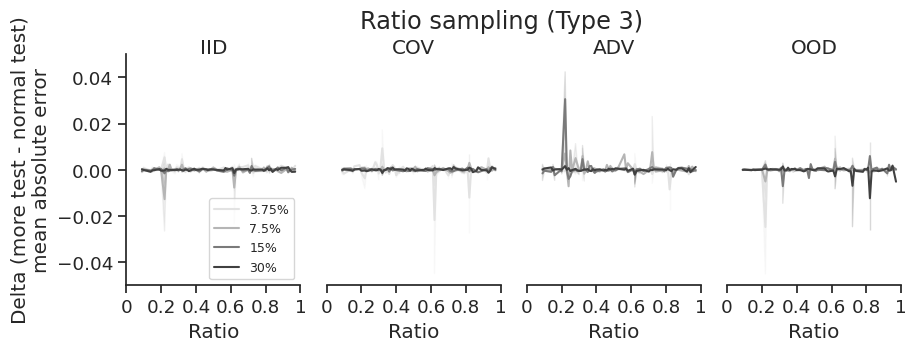

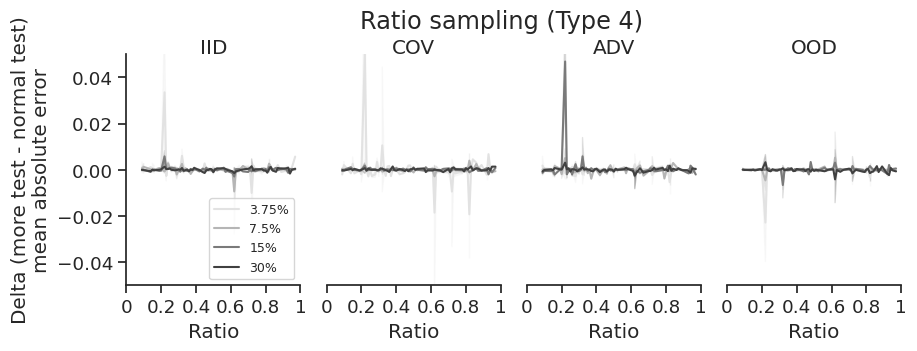

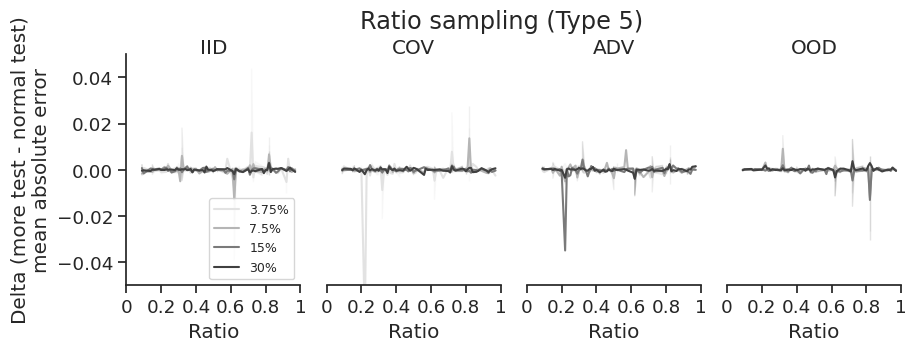

In [23]:
#################### Study III Ratio sampling difference from baseline  #################### by downsample level
sns.set(style="ticks", font_scale=1.2)

df_load = (
    cnn_more[(cnn_more.Exp == "Ratio") & (cnn_more.Level.isin([2, 4, 8, 16]))]
    .groupby(["Run", "Type", "Method", "Level", "Ratio", "Test"])[["absError"]]
    .mean()
    .reset_index()
    .pivot(
        index=["Run", "Type", "Method", "Level", "Ratio"],
        columns="Test",
        values="absError",
    )
    .reset_index()
    .dropna()
)
df_load["diff"] = df_load["More"] - df_load["Normal"]

# for model in ["VGG", "ResNet"]:
for bartype in range(1, 6):
    fig, ax = plt.subplots(ncols=4, figsize=(10, 3))  # (7,3)
    for idx, method in enumerate(["IID", "COV", "ADV", "OOD"]):
        df_plot = df_load[
            (df_load["Method"] == method)
            # & (df_load.Model == model)
            & (df_load.Type == bartype)
        ].copy()
        df_plot.loc[df_plot["Level"] == 2, "newLevel"] = "30%"
        df_plot.loc[df_plot["Level"] == 4, "newLevel"] = "15%"
        df_plot.loc[df_plot["Level"] == 8, "newLevel"] = "7.5%"
        df_plot.loc[df_plot["Level"] == 16, "newLevel"] = "3.75%"
        # df_plot.sort_values('Level', ascending=False, inplace=True)

        g = sns.lineplot(
            x="Ratio",
            y="diff",
            hue="newLevel",
            hue_order=["3.75%", "7.5%", "15%", "30%"],
            data=df_plot,
            palette="Greys",
            ax=ax[idx],
        )

        g.set(xlim=(0, 1))
        g.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        g.set_xlabel("Ratio")
        g.set(ylim=(-0.05, 0.05))
        g.set_ylabel("")
        if idx == 0:
            g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
            # g.set_yticks([-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1])
            # g.set_yticklabels(['', '-0.6', '-0.4', '-0.2', '0', ''])
            g.set_ylabel("Delta (more test - normal test)\nmean absolute error")
            ax[idx].legend(fontsize=9, loc="lower right")
        else:
            g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
            ax[idx].set_yticklabels("")
            ax[idx].yaxis.set_ticks_position("none")
            ax[idx].spines["left"].set_visible(False)
            ax[idx].legend_.remove()

        g.set_title(method, y=0.97)
        ax[idx].spines["right"].set_visible(False)
        ax[idx].spines["top"].set_visible(False)
    plt.suptitle(f"Ratio sampling (Type {bartype})", y=1.03)
    plt.subplots_adjust(wspace=0.15)

    fname = f"DeltaMoreVsRatio_Type{bartype}.pdf"
    plt.savefig(
        f"{figure_path}/DeltaMoreVsRatio/{fname}",
        format="pdf",
        bbox_inches="tight",
    )
    plt.show()

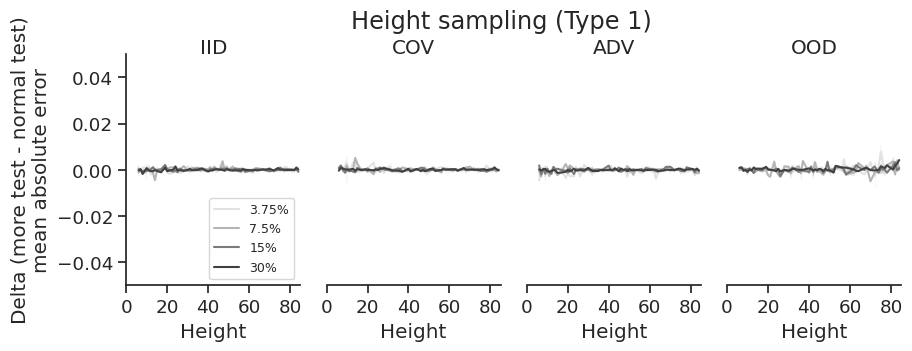

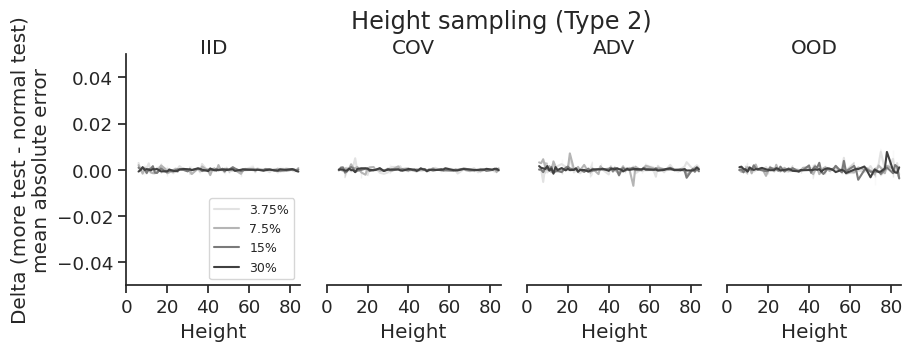

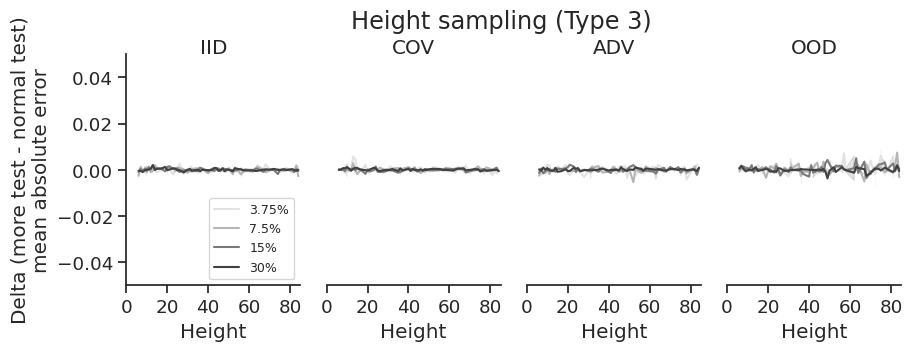

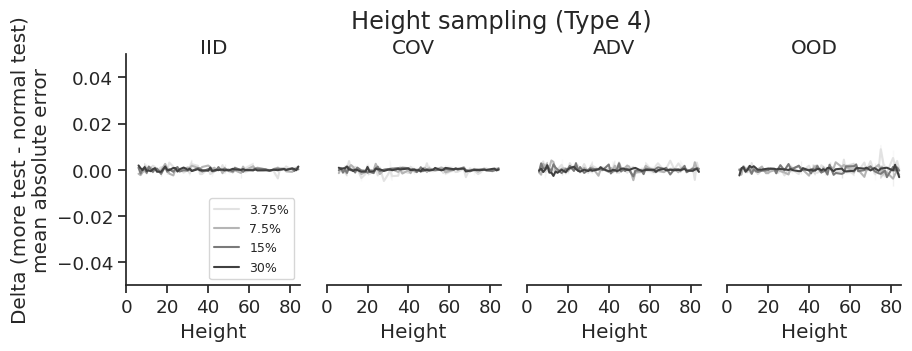

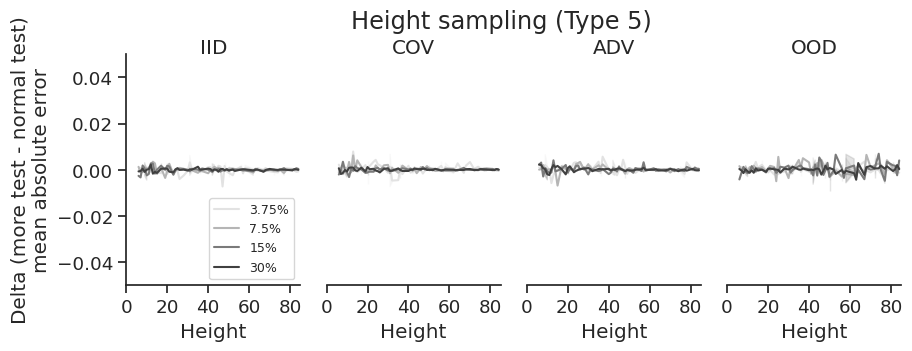

In [25]:
#################### Study III Ratio sampling difference from baseline  #################### by downsample level
sns.set(style="ticks", font_scale=1.2)

df_load = (
    cnn_more[(cnn_more.Exp == "Height") & (cnn_more.Level.isin([2, 4, 8, 16]))]
    .groupby(["Run", "Type", "Method", "Level", "H", "Test"])[["absError"]]
    .mean()
    .reset_index()
    .pivot(
        index=["Run", "Type", "Method", "Level", "H"],
        columns="Test",
        values="absError",
    )
    .reset_index()
    .dropna()
)
df_load["diff"] = df_load["More"] - df_load["Normal"]

# for model in ["VGG", "ResNet"]:
for bartype in range(1, 6):
    fig, ax = plt.subplots(ncols=4, figsize=(10, 3))  # (7,3)
    for idx, method in enumerate(["IID", "COV", "ADV", "OOD"]):
        df_plot = df_load[
            (df_load["Method"] == method)
            # & (df_load.Model == model)
            & (df_load.Type == bartype)
        ].copy()
        df_plot.loc[df_plot["Level"] == 2, "newLevel"] = "30%"
        df_plot.loc[df_plot["Level"] == 4, "newLevel"] = "15%"
        df_plot.loc[df_plot["Level"] == 8, "newLevel"] = "7.5%"
        df_plot.loc[df_plot["Level"] == 16, "newLevel"] = "3.75%"
        # df_plot.sort_values('Level', ascending=False, inplace=True)

        g = sns.lineplot(
            x="H",
            y="diff",
            hue="newLevel",
            hue_order=["3.75%", "7.5%", "15%", "30%"],
            data=df_plot,
            palette="Greys",
            ax=ax[idx],
        )

        g.set(xlim=(0, 85))
        g.set_xticks([0, 20, 40, 60, 80])
        g.set_xlabel("Height")
        g.set(ylim=(-0.05, 0.05))
        g.set_ylabel("")
        if idx == 0:
            # g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
            # g.set_yticks([-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1])
            # g.set_yticklabels(['', '-0.6', '-0.4', '-0.2', '0', ''])
            g.set_ylabel("Delta (more test - normal test)\nmean absolute error")
            ax[idx].legend(fontsize=9, loc="lower right")
        else:
            # g.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
            ax[idx].set_yticklabels("")
            ax[idx].yaxis.set_ticks_position("none")
            ax[idx].spines["left"].set_visible(False)
            ax[idx].legend_.remove()

        g.set_title(method, y=0.97)
        ax[idx].spines["right"].set_visible(False)
        ax[idx].spines["top"].set_visible(False)
    plt.suptitle(f"Height sampling (Type {bartype})", y=1.03)
    plt.subplots_adjust(wspace=0.15)

    fname = f"DeltaMoreVsHeight_Type{bartype}.pdf"
    plt.savefig(
        f"{figure_path}/DeltaMoreVsHeight/{fname}",
        format="pdf",
        bbox_inches="tight",
    )
    plt.show()

# Toy Example

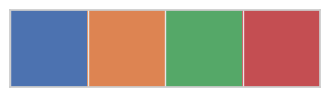

In [14]:
sns.set()
sns.set_style("whitegrid", {"grid.color": ".9"})
flat = ["#4c72b0", "#dd8452", "#55a868", "#c44e52"]
sns.palplot(sns.color_palette(flat))

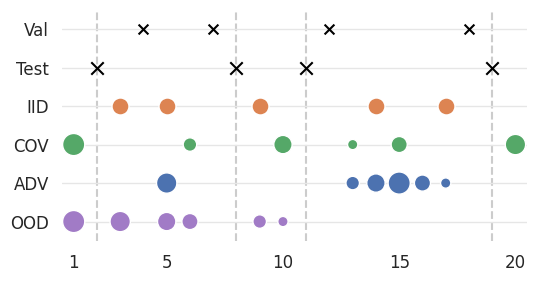

In [16]:
color_deep4 = ["#dd8452", "#55a868", "#4c72b0", "#a17bc6"]
sns.set_palette(color_deep4)

METHOD = "IID"
RUN = 23
DIVISOR = 2

np.random.seed(int(RUN))
random.seed(int(RUN))
all_ratios = list(range(1, 21))
random.shuffle(all_ratios)

testNum = int(round(len(all_ratios) * 0.2))
valNum = int(round(len(all_ratios) * 0.2))
trainNum = len(all_ratios) - valNum - testNum
# test ratios:
# test_ratios = all_ratios[valNum:valNum+testNum]
# val_ratios = all_ratios[:valNum]
# train_ratios_org = all_ratios[testNum+valNum:]
test_ratios = [2, 10, 13, 19]
val_ratios = [3, 9, 14, 17]
test_ratios = [21 - i for i in test_ratios]
val_ratios = [21 - i for i in val_ratios]
train_ratios_org = list(set(all_ratios) - set(test_ratios) - set(val_ratios))

train_ratios_iid = train_ratios_org[: int(round(trainNum // int(DIVISOR)))]
train_ratios_iid = [3, 5, 9, 14, 17]

train_ratios_ood = sorted(train_ratios_org)[: int(round(trainNum // int(DIVISOR)))]

distance = [
    min([abs(train - test) for test in test_ratios]) for train in train_ratios_org
]
# distance = [sum(sorted([abs(train-test) for test in test_ratios])[:2]) for train in train_ratios_org]
train_ratios_adv = sorted(
    train_ratios_org, reverse=True, key=lambda x: distance[train_ratios_org.index(x)]
)[: int(round(trainNum // int(DIVISOR)))]
train_ratios_adv = [15, 5, 14, 16, 13, 17]

cov_order = []
train_ratios_cov = sorted(train_ratios_org)
selected_ratios = []
selected_ratios.append(train_ratios_cov.pop(0))
selected_ratios.append(train_ratios_cov.pop(-1))

for run in range(int(round(trainNum // int(DIVISOR))) - 2):
    distance = [
        min([abs(train - selected) for selected in selected_ratios])
        for train in train_ratios_cov
    ]
    train_ratios_cov = sorted(
        train_ratios_cov,
        reverse=True,
        key=lambda x: distance[train_ratios_cov.index(x)],
    )
    selected_ratios.append(train_ratios_cov.pop(0))

train_ratios_cov = selected_ratios

fig = plt.figure(figsize=(6, 3))

n = trainNum // DIVISOR
size = [40 * (n - i) + 15 for i in range(n)]
for i in test_ratios:
    plt.plot([i, i], [-0.5, 5.5], linestyle="--", color="#cccccc", zorder=0)
plt.scatter(x=val_ratios, y=[5] * len(val_ratios), color="black", marker="x", s=50)
plt.scatter(x=test_ratios, y=[4] * len(test_ratios), color="black", marker="x", s=80)
# plt.scatter(x=train_ratios_iid, y=[3] * len(train_ratios_iid), marker='o', s=size, edgecolors='white', linewidths=1)
plt.scatter(
    x=train_ratios_iid,
    y=[3] * len(train_ratios_iid),
    marker="o",
    s=150,
    edgecolors="white",
    linewidths=1,
)
plt.scatter(
    x=train_ratios_cov,
    y=[2] * len(train_ratios_cov),
    marker="o",
    s=size,
    edgecolors="white",
    linewidths=1,
)
plt.scatter(
    x=train_ratios_adv,
    y=[1] * len(train_ratios_adv),
    marker="o",
    s=size,
    edgecolors="white",
    linewidths=1,
)
plt.scatter(
    x=train_ratios_ood,
    y=[0] * len(train_ratios_ood),
    marker="o",
    s=size,
    edgecolors="white",
    linewidths=1,
)


sns.despine(top=True, left=True, bottom=True, trim=0)
plt.ylim(-0.5, 5.5)
plt.xlim(0.5, 20.5)
plt.gca().xaxis.grid(False)
plt.yticks([0, 1, 2, 3, 4, 5], ["OOD", "ADV", "COV", "IID", "Test", "Val"], fontsize=12)
plt.xticks([1] + list(range(5, 21, 5)), fontsize=12)
plt.savefig(f"toy_example.svg", bbox_inches="tight", pad_inches=0, transparent=False)
plt.show()

# Five types

In [17]:
import ../exp/ClevelandMcGill as C

SyntaxError: invalid syntax (2695688586.py, line 1)

# Sample Space

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap

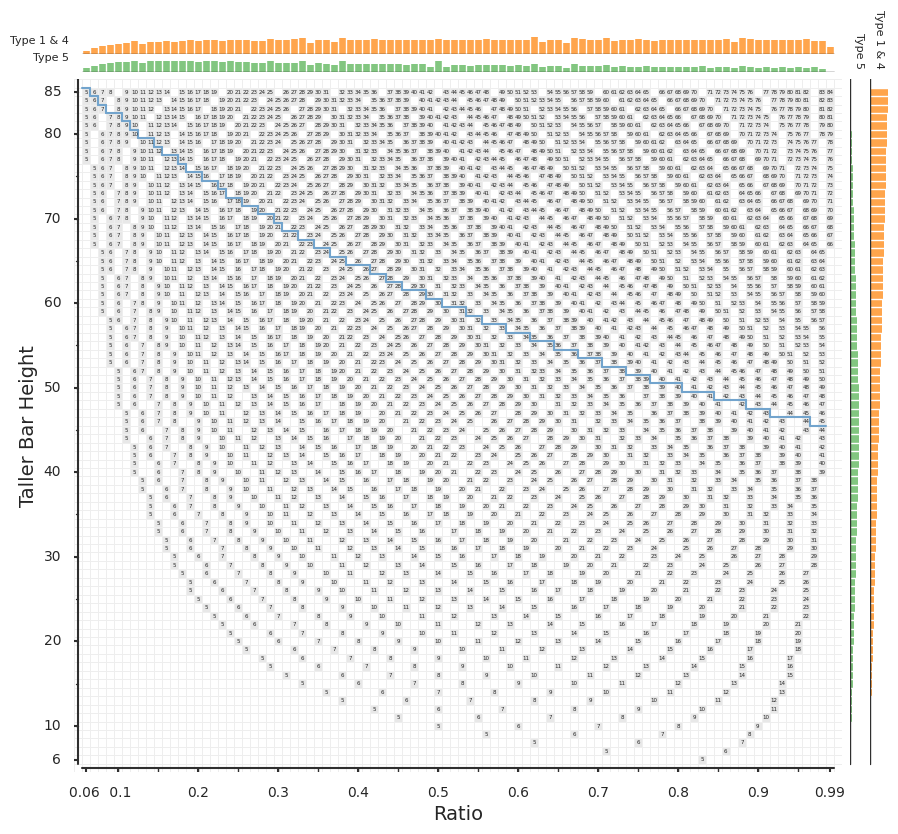

In [20]:
H = range(5, 86)
P = [(i, j) for i in H for j in H if i < j]
ratio_pair = {}  # {r1:[p1,p2...], r2:[p1, p2...]}
for p in P:
    r = round(min(p) / max(p), 2)
    if r not in ratio_pair:
        ratio_pair[r] = [p]
    else:
        ratio_pair[r].append(p)
all_ratios = list(ratio_pair.keys())

m = np.zeros((101, 101))
# m[:] = np.nan
text = [["" for i in range(100)] for j in range(100)]
for h1 in range(6, 86):
    for h2 in range(5, h1):
        r = np.round(h2 / h1, 2)
        if m[h1][int(np.round(r * 100))] != 0:
            print(r, h1, h2, m[h1][int(np.round(r * 100))])
        else:
            m[h1][int(np.round(r * 100))] = h2

mask_tcl = np.zeros((101, 101))
for h1 in [25, 50, 75]:
    for r in [18, 26, 38, 46, 56, 68, 83]:
        h2 = np.round(h1 * r / 100)
        h2 = h2 if h2 >= 5 else 5
        rr = np.round(h2 / h1, 2)
        mask_tcl[int(h1)][int(np.round(rr * 100))] = 1

mask_cm = np.zeros((101, 101))
Hcm = [10.0, 12.0, 15.0, 18.0, 22.0, 26.0, 32.0, 38.0, 46.0, 56.0]
Pcm = [(i, j) for i in Hcm for j in Hcm if i < j]
ratio_pair_cm = {}  # {r1:[p1,p2...], r2:[p1, p2...]}
for p in Pcm:
    r = round(min(p) / max(p), 2)
    if r not in ratio_pair_cm:
        ratio_pair_cm[r] = [max(p)]
    else:
        ratio_pair_cm[r].append(max(p))
for not_used_ratio in [0.21, 0.22, 0.31, 0.32, 0.33]:
    del ratio_pair_cm[not_used_ratio]
for r in ratio_pair_cm.keys():
    for h in ratio_pair_cm[r]:
        mask_cm[int(h)][int(np.round(r * 100))] = 1

fig = plt.figure(figsize=(11, 10))
sns.set_style("whitegrid", {"grid.color": ".1"})

plt.subplots_adjust(hspace=0.02, wspace=0.02)
outer = gridspec.GridSpec(2, 2, height_ratios=[4, 40], width_ratios=[40, 4], figure=fig)
# make nested gridspecs
gs_up = gridspec.GridSpecFromSubplotSpec(
    4, 1, subplot_spec=outer[0], wspace=0.0, hspace=0.05
)
gs_right = gridspec.GridSpecFromSubplotSpec(
    1, 4, subplot_spec=outer[3], wspace=0.05, hspace=0.0
)
gs_main = gridspec.GridSpecFromSubplotSpec(
    1, 1, subplot_spec=outer[2], wspace=0, hspace=0
)


ax = plt.subplot(gs_main[0])

sns.heatmap(
    m,
    mask=(m == 0),
    linewidths=0.5,
    linecolor="#eeeeee",
    cmap=ListedColormap(["#e8e8e8"]),
    annot=True,
    cbar=False,
    ax=ax,
    annot_kws={"fontsize": 4},
)

h, r = 85, 6
while r < 99:
    ax.plot([r, r + 1], [h + 1, h + 1], linewidth=1.5, c="#72a4cd")
    try:
        if (
            (m[h][r + 1] != 0 and h + m[h][r + 1] <= 90)
            or (m[h][r + 2] != 0 and h + m[h][r + 2] <= 90)
            or (m[h][r + 3] != 0 and h + m[h][r + 3] <= 90)
        ):
            r += 1
        else:
            ax.plot([r + 1, r + 1], [h + 1, h + 1 - 1], linewidth=1.5, c="#72a4cd")
            r += 1
            h -= 1
    except:
        r += 1


ax.plot([5.5, 5.5], [6, 100], c="#2f2f2f", linewidth=1.5)
for y in list(range(10, 100, 10)) + [85]:
    ax.plot([5, 5.5], [y + 0.5, y + 0.5], c="#2f2f2f", linewidth=1.5)
ax.plot([5, 5.5], [6 + 0.5, 6 + 0.5], c="#2f2f2f", linewidth=1.5)
for y in range(10, 100, 5):
    ax.plot([5.2, 5.5], [y + 0.5, y + 0.5], c="#2f2f2f", linewidth=1)
ax.set_yticks([6.5] + [i + 0.5 for i in range(10, 85, 10)] + [85.5])
ax.set_yticklabels([6] + [i for i in range(10, 85, 10)] + [85], fontsize=10, rotation=0)

ax.plot([6, 100], [5.5, 5.5], c="#2f2f2f", linewidth=1.5)
for x in list(range(10, 100, 10)) + [99]:
    ax.plot([x + 0.5, x + 0.5], [5.5, 5], c="#2f2f2f", linewidth=1.5)
ax.plot([6 + 0.5, 6 + 0.5], [5.5, 5], c="#2f2f2f", linewidth=1.5)
for x in range(10, 100, 5):
    ax.plot([x + 0.5, x + 0.5], [5.5, 5], c="#2f2f2f", linewidth=1)
ax.set_xticks([6.5] + [i + 0.5 for i in range(10, 100, 10)] + [99.5])
ax.set_xticklabels(
    ["0.06 ", " 0.1"] + [f"{i/100:.1f}" for i in range(20, 100, 10)] + [0.99],
    fontsize=10,
    rotation=0,
)

ax.set_xlim(5, 101)
ax.set_ylim(5, 87)
ax.set_xlabel("Ratio", fontsize=14)
ax.set_ylabel("Taller Bar Height", fontsize=14)
ax.grid(False)

for draw_up in range(1):
    # Type 1 distribution
    ax = plt.subplot(gs_up[2])
    m_up = np.zeros((50, 100))
    max_num = 0
    for r in range(6, 100):
        num = np.sum(m[:, r] != 0)
        max_num = num if num > max_num else max_num
        for i in range(num):
            m_up[i][r] = 1
    sns.heatmap(
        m_up,
        mask=(m_up == 0),
        linewidths=0.000,
        linecolor="#ffa54c",
        cmap=ListedColormap(["#ffa54c"]),
        cbar=False,
        ax=ax,
    )
    for i in range(m_up.shape[1] + 1):
        ax.axvline(i, color="white", lw=1)
    ax.plot([6, 100], [0, 0], c="#2f2f2f", linewidth=1)
    ax.set_xlim(5, 101)
    ax.set_ylim(0, max_num)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("Type 1 & 4", fontsize=8, rotation=0, ha="right")

    # Type 5 distribution
    ax = plt.subplot(gs_up[3])
    m_up = np.zeros((50, 100))
    # max_num = 0
    for r in range(6, 100):
        # num = np.sum(m[:46, r]!=0)
        num = 0
        for h in range(6, 85):
            if m[h][r] != 0 and h + m[h][r] <= 90:
                num += 1
        # max_num = num if num > max_num else max_num
        for i in range(num):
            m_up[i][r] = 1
    sns.heatmap(
        m_up,
        mask=(m_up == 0),
        linewidths=0.000,
        linecolor="#82c680",
        cmap=ListedColormap(["#82c680"]),
        cbar=False,
        ax=ax,
    )
    for i in range(m_up.shape[1] + 1):
        ax.axvline(i, color="white", lw=1)
    ax.plot([6, 100], [0, 0], c="#2f2f2f", linewidth=1)
    ax.set_xlim(5, 101)
    ax.set_ylim(0, max_num)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("Type 5", fontsize=8, rotation=0, ha="right")


for draw_right in range(1):
    # Type 1 distribution
    ax = plt.subplot(gs_right[1])
    m_up = np.zeros((100, 100))
    max_num = 0
    for h in range(6, 86):
        num = np.sum(m[h, :] != 0)
        max_num = num if num > max_num else max_num
        for i in range(num):
            m_up[h][i] = 1
    sns.heatmap(
        m_up,
        mask=(m_up == 0),
        linewidths=0.000,
        linecolor="#ffa54c",
        cmap=ListedColormap(["#ffa54c"]),
        cbar=False,
        ax=ax,
    )
    for i in range(m_up.shape[0] + 1):
        ax.axhline(i, color="white", lw=1)
    ax.plot([0, 0], [6, 100], c="#2f2f2f", linewidth=1)
    ax.set_xlim(0, max_num)
    ax.set_ylim(5, 87)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_position("top")
    ax.set_xlabel("Type 1 & 4  ", fontsize=8, rotation=270)

    # Type 5 distribution
    ax = plt.subplot(gs_right[0])
    m_up = np.zeros((100, 100))
    # max_num = 0
    for h in range(6, 86):
        # num = np.sum(m[h, :]!=0)
        # max_num = num if num > max_num else max_num
        num = 0
        for r in range(6, 100):
            if m[h][r] != 0 and h + m[h][r] <= 90:
                num += 1
        for i in range(num):
            m_up[h][i] = 1
    sns.heatmap(
        m_up,
        mask=(m_up == 0),
        linewidths=0.000,
        linecolor="#82c680",
        cmap=ListedColormap(["#82c680"]),
        cbar=False,
        ax=ax,
    )
    for i in range(m_up.shape[0] + 1):
        ax.axhline(i, color="white", lw=1)
    ax.plot([0, 0], [6, 100], c="#2f2f2f", linewidth=1)
    ax.set_xlim(0, max_num)
    ax.set_ylim(5, 87)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_position("top")
    ax.set_xlabel("Type 5  ", fontsize=8, rotation=270)


plt.savefig("test.pdf", bbox_inches="tight", pad_inches=0)

plt.show()